In [1]:
# General python libraries and packages
import numpy as np
import pandas as pd
import math
import itertools
import re
import sys
import os

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Accessing Databases
import requests
from tqdm.auto import tqdm
from chembl_webresource_client.new_client import new_client

# Processing chemical data
from rdkit import Chem
from rdkit.Chem import rdFMCS, PandasTools, Draw, rdmolops
from rdkit.Chem.Draw import MolDrawing, DrawingOptions, IPythonConsole

# See https://greglandrum.github.io/rdkit-blog/posts/2023-12-01-using_sascore_and_npscore.html
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from NP_Score import npscorer

In [ ]:
# Adjust how molecules are drawn! 
dpi = 300
canvas_size = 600  
d2d = Draw.MolDraw2DCairo(canvas_size, canvas_size) # Use a fixed canvas size
dopts = d2d.drawOptions()
dopts.fixedFontSize = 14
dopts.legendFontSize = 16
dopts.dummiesAreAttachments = True # Replace * by wavy lines
# dopts.addStereoAnnotation = True

# Print all the drawing options
# for attr in dir(dopts):
#      if not attr.startswith('_') and not callable(getattr(dopts, attr)):
#         try:
#             print(f"{attr}: {getattr(dopts, attr)}")
#         except Exception as e:
#             print(f"{attr}: <error reading value: {e}>")

# Set the drawOptions variable in the PandasTools module accordingly
PandasTools.drawOptions = dopts

# Also set how molecules are rendered within the Jupyter Notebook
IPythonConsole.drawOptions = dopts

Read in CrystalsFirst Fragments' Data

In [ ]:
CF_df = pd.read_excel('Data/_Molecule_Data_Combined.xlsx', usecols=['Dataset', 'ID', 'Standardized_SMILES']) 
CF_df = CF_df[CF_df['Dataset'] == 'CF'] 
CF_df = CF_df.rename(columns={"Standardized_SMILES":"CF_SMILES", 'ID':'CF_FRG'}) 
CF_df = CF_df.drop(columns=['Dataset'])

PandasTools.AddMoleculeColumnToFrame(CF_df, smilesCol="CF_SMILES", molCol='CF_2D_Mol')
PandasTools.RenderImagesInAllDataFrames(images=True)
print(len(CF_df))
CF_df.head(1)

# COCONUT Database
Read in the Natural Products (NPs) listed in the COCONUT database. 

In [ ]:
# File downloaded from https://coconut.naturalproducts.net/download
COCONUT_df = pd.read_csv("Data/COCONUT/COCONUT_DB_202408.csv", delimiter=",")
COCONUT_df = COCONUT_df.drop(columns=['standard_inchi', 'standard_inchi_key'])
COCONUT_df = COCONUT_df.rename(columns={'canonical_smiles': 'COCONUT_SMILES', 'identifier':'COCONUT_ID'})

print(len(COCONUT_df))
COCONUT_df.head()

Alternative, use may wish to use the COCONUT API <br>
- https://github.com/Steinbeck-Lab/coconut/
- https://coconut.naturalproducts.net/api-documentation

# Substructures
Which Natural Products from the COCONUT database comprise a CrystalsFirst Fragment as a substructure?

In [ ]:
# Initialize empty lists to store results
CF_FRG = []
CF_SMILES = []
COCONUT_NP_SMILES = []
COCONUT_ID = []
substructure = [] 

# Iterate over the CF Frags and convert them to a query object for the substructure search
for index, row in CF_df.iterrows():
    
    # Keep track, which FRG is the current query input
    current_CF_SMILES = row['CF_SMILES']
    current_CF_FRG = row['CF_FRG']
    
    # Extract the substructure to be searched for
    h = row['CF_2D_Mol']

    # As the substructure is in SMILES format, we need to convert the dummies into queries first
    # See https://github.com/rdkit/rdkit/discussions/5480 for reference
    # Define the parameters controlling which components of the query atoms/bonds are adjusted.
    # Initially, set all AdjustQueryParameters parameters to False
    p = Chem.AdjustQueryParameters.NoAdjustments()
    p.makeDummiesQueries = True
    hq = Chem.AdjustQueryProperties(h, p)

    # Perform the actual substructure search 
    # Iterate over each SMILES in the COCONUT_SMILES list
    for index, row in COCONUT_df.iterrows():
        
        current_COCONUT_SMILES = row['COCONUT_SMILES']
        current_COCONUT_ID = row['COCONUT_ID']

        # As we need a SMILES, check if there is one
        # If not, end this iteration early, i.e. skip this COCONUT molecule
        if current_COCONUT_SMILES is None:
            continue
        
        # Generate molecule from smiles for every COCONUT_SMILES
        COCONUT_Molecule = Chem.MolFromSmiles(current_COCONUT_SMILES)

        # As we need a SMILES, check if there is one
        # If not, end this iteration early, i.e. skip this COCONUT molecule
        if COCONUT_Molecule is None:
            print(f"Could not generate molecule from SMILES for COCONUT SMILES {current_COCONUT_SMILES}")
            continue

        # Append the current SMILES string to the COCONUT_NP_SMILES list 
        # if it has a substructure match with the current query object hq
        if COCONUT_Molecule.HasSubstructMatch(hq):
            CF_FRG.append(current_CF_FRG)
            CF_SMILES.append(current_CF_SMILES)
            COCONUT_ID.append(current_COCONUT_ID)
            COCONUT_NP_SMILES.append(current_COCONUT_SMILES)
            substructure.append(Chem.MolToSmiles(hq))
            
# Create a pandas DataFrame 
data = {'CF_FRG' : CF_FRG,
        'CF_SMILES' : CF_SMILES, 
        'COCONUT_SMILES': COCONUT_NP_SMILES, 
        'COCONUT_ID': COCONUT_ID,
        'Substructure_SMILES': substructure, # Just for quality control, should be the molecule as the CF Fragment!
        }

NPs_df = pd.DataFrame(data)
PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="COCONUT_SMILES", molCol='COCONUT_2D_Mol')
PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="CF_SMILES", molCol='CF_2D_Mol') 
#PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="Substructure_SMILES", molCol='Substructure_2D_Mol') 

print(len(NPs_df))

In [ ]:
PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="Substructure_SMILES", molCol='Substructure_2D_Mol') 

# Adjust the orientation of the COCONUT_2D_Mol the same way as the CF_2D_Mol
# Adds column with SMILES of Murcko scaffolds to pandas DataFrame.
PandasTools.AddMurckoToFrame(NPs_df, molCol='CF_2D_Mol', MurckoCol='Murcko_SMILES', Generic=False)
# Aligns molecules in molCol to scaffolds in scaffoldCol
PandasTools.AlignToScaffold(NPs_df, molCol='COCONUT_2D_Mol', scaffoldCol='Murcko_SMILES')
NPs_df.head(2)

In [ ]:
PandasTools.RenderImagesInAllDataFrames(images=True)

# Save to file
NPs_df.copy().drop(columns=['Substructure_2D_Mol', 'CF_2D_Mol', 'COCONUT_2D_Mol']).to_csv(
    'Analysis/NPs/NPs_with_CF_FRG_substructure.csv', index=False)

NPs_df.head(1)

In [ ]:
# Write to .sdf file
PandasTools.WriteSDF(NPs_df,                        # DataFrame to store as .sdf file
                     "Analysis/NPs/NPs_with_CF_FRG_substructure.sdf",       # File path and name 
                     molColName='COCONUT_2D_Mol', # Define the name of the Molecule column
                     properties=list(NPs_df.columns),         # Export all columns
                     )

## NPs per Fragment

In [ ]:
unique_count_NP = NPs_df.groupby('CF_FRG')['COCONUT_SMILES'].nunique().reset_index().rename(columns={'COCONUT_SMILES': 'COCONUT_NP_Count'})

no_NPs = sorted(list(set(list(CF_df['CF_FRG'].unique())) - set(list(NPs_df['CF_FRG'].unique()))))
print(f"However, no NPs were identified for Fragments {no_NPs}")

unique_count_NP = pd.concat([unique_count_NP, pd.DataFrame({'CF_FRG': no_NPs, 'COCONUT_NP_Count': [0] * len(no_NPs)})], ignore_index=True)
unique_count_NP = unique_count_NP.sort_values(by='CF_FRG')
unique_count_NP

Bar plot, to visualize the unique_count_NP

In [ ]:
plt.figure(figsize=(12, 12))

# Create a bar plot with COCONUT_NP_Count as bar size and CF_FRG as labels
ax = unique_count_NP.plot(
    kind="bar",
    x="CF_FRG", 
    y="COCONUT_NP_Count",
    color="lightgray",
)

# Customize the plot
ax.set_xlabel("CrystalsFirst Fragments")
ax.set_ylabel("Number of associated NPs in the COCONUT database")
ax.tick_params(axis="x", labelsize=8)  # Modify the font size for x-axis
ax.legend_.remove()

# Add numbers to each bar
for i, v in enumerate(unique_count_NP["COCONUT_NP_Count"]):
    ax.text(i, v + 5, str(v), color="black", fontsize=8, horizontalalignment='center')

# Save the figure
plt.tight_layout()
plt.savefig("Analysis/NPs/Barplot_NPs_per_CFfragment.png")

# Show the plot
plt.show()

## Maximum Common Substructure (MCSS) 
MCSS of the Natural Products, that were identified to comprise the CF Fragment substructure.

By definition, the MCSS comprises at least the CF Fragment. <br>
But is the MCSS identical to the latter, or is it bigger? 

In [ ]:
mcs_images = [] 

#Iterate over each unique CF_SMILES 
for current_CF_FRG in NPs_df['CF_FRG'].unique():

    # Filter the dataframe for the specific CF_FRG
    sub_df = NPs_df[NPs_df['CF_FRG'] == current_CF_FRG]

    # Initialize variables to store the MCSS information
    max_count = 0
    max_mcs_smarts = ''

    # Iterate over each row in the filtered dataframe
    for index, row in sub_df.iterrows():

        current_CF_FRG = row['CF_FRG']
        current_CF_SMILES = row['CF_SMILES']
        current_CF_Mol = row['CF_2D_Mol']
        current_NP_Mol = row['COCONUT_2D_Mol']

        # Find MCSS
        res = rdFMCS.FindMCS([current_NP_Mol, current_CF_Mol])
        mcs_smarts = res.smartsString

        # Count occurrences of the current MCSS
        count = sub_df[sub_df['COCONUT_SMILES'] == row['COCONUT_SMILES']].shape[0]

        # Update MCSS if current count is higher
        if count > max_count:
            max_count = count
            max_mcs_smarts = mcs_smarts

    # Draw image for the MCSS for each CF_FRG
    if (current_CF_SMILES, max_mcs_smarts) not in [(img[0], img[1]) for img in mcs_images]:
        mcs_mol = Chem.MolFromSmarts(max_mcs_smarts)
        mcs_images.append((current_CF_FRG, current_CF_SMILES, max_mcs_smarts, mcs_mol, current_CF_Mol))

# Create a grid image with all unique most common substructures and original structures underneath each other
mols_to_draw = []
legends = []
for current_CF_FRG, current_CF_SMILES, _, mcs_mol, original_mol in mcs_images:
    mols_to_draw.extend([original_mol, mcs_mol])
    legends.extend([f'{current_CF_FRG}', 'MCSS of associated NPs'])

img = Draw.MolsToGridImage(mols_to_draw, legends=legends, molsPerRow=2)

# Display the grid image with all unique most common substructures and original structures underneath each other
display(img)

#img.save('Analysis/NPs/CF_Frag_and_NP_MCSS.png')

FRG structure and MCSS of the associates NPs are the same in all cases. 

## Exit vectors in the Fragments (as present in the NPs)

In [3]:
# Short-Cut!
NPs_df = pd.read_csv('Analysis/NPs/NPs_with_CF_FRG_substructure.csv')
PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="CF_SMILES", molCol='CF_2D_Mol')
PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="COCONUT_SMILES", molCol='COCONUT_2D_Mol')
PandasTools.AddMoleculeColumnToFrame(NPs_df, smilesCol="Substructure_SMILES", molCol='Substructure_2D_Mol')
print(len(NPs_df))

1675


,CF_FRG,CF_SMILES,COCONUT_SMILES,COCONUT_ID,Substructure_SMILES,Murcko_SMILES,Exit_Atom_Numbers,Num_Exit_Atoms,Substructure_Exit_Atoms,CF_2D_Mol,COCONUT_2D_Mol,Substructure_2D_Mol
0,F005,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,O[C@@H]1C[C@@H](C2=NC(C3=CN=CC=N3)=NO2)N(CC2=C...,CNP0410447.1,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,c1cnc(-c2noc([C@@H]3CCCN3)n2)cn1,[3],1,<rdkit.Chem.rdchem.Mol object at 0x79a69e184c70>,,,

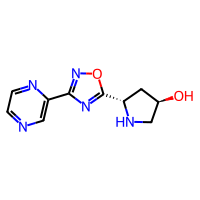
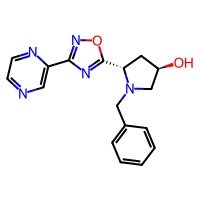
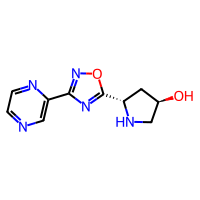

In [4]:
def orientate_mols(df, mol_cols, scaffold_col):
    """
    Adds a column with SMILES of Murcko scaffolds to the DataFrame and aligns other molecule columns to this scaffold.

    Parameters:
    - df (pd.DataFrame):  DataFrame containing the molecule data.
    - mol_cols (list):    List of molecule column names to align to the scaffold.
    - scaffold_col (str): Column name of the scaffold to align to.

    Returns:
    - pd.DataFrame: The modified DataFrame after processing.
    """
    # Add Murcko scaffolds to the DataFrame
    PandasTools.AddMurckoToFrame(df, molCol=scaffold_col, MurckoCol='Murcko', Generic=False)

    # Align molecules in specified columns to the Murcko scaffolds
    for mol_col in mol_cols:
        try:
            PandasTools.AlignToScaffold(df, molCol=mol_col, scaffoldCol='Murcko')
        except Exception as e:
            print(f"Error aligning {mol_col} to Murcko: {e}")
            continue

    # Drop specified helper Murcko column from the DataFrame
    df = df.drop(columns=['Murcko'])

    return df

NPs_df = orientate_mols(NPs_df, scaffold_col = 'CF_2D_Mol',
                        mol_cols = ['CF_2D_Mol', 'COCONUT_2D_Mol', 'Substructure_2D_Mol'])

PandasTools.RenderImagesInAllDataFrames(images=True)

NPs_df.head(1)

### Identify Exit Atoms

,CF_FRG,CF_SMILES,COCONUT_SMILES,COCONUT_ID,Substructure_SMILES,Murcko_SMILES,Exit_Atom_Numbers,Num_Exit_Atoms,Substructure_Exit_Atoms,CF_2D_Mol,COCONUT_2D_Mol,Substructure_2D_Mol
0,F005,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,O[C@@H]1C[C@@H](C2=NC(C3=CN=CC=N3)=NO2)N(CC2=C...,CNP0410447.1,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,c1cnc(-c2noc([C@@H]3CCCN3)n2)cn1,[3],1,,,,

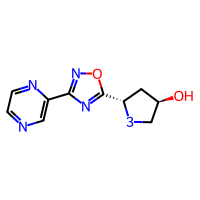
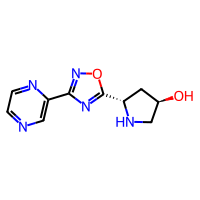
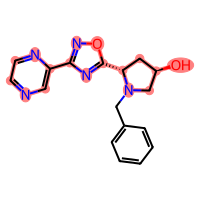
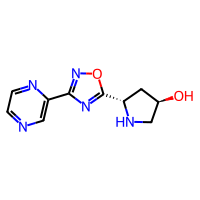

In [5]:
def identify_exit_atoms(substructure_mol, parent_mol):
    """ 
    Identify exit atoms in a molecule,  i.e. atoms whose substitution can be modified. => Growth/Exit Vectors 

    Returns: 
        A list of the atom numbers of the exit atoms.
    """
    
    # Initialize an empty list to store the exit atoms
    exit_atoms = []

    # Highlight the substructure in the parent molecules, i.e. in the NP
    substruct_match = parent_mol.GetSubstructMatch(substructure_mol)
    
    # Iterate over the atoms in the substructure
    for atom in substructure_mol.GetAtoms():
        # Get the atom index
        atom_idx = atom.GetIdx()
        
        # Find the corresponding atom in the parent molecule 
        # substructure-based, as the numbering is not consistent across the two molecules!        
        parent_atom_idx = substruct_match[atom_idx] 
        parent_atom = parent_mol.GetAtomWithIdx(parent_atom_idx)       

        # If the parent atom has more non-hydrogen neighbor atoms than the substructure atom, 
        # add the substructure atom index to the exit_atoms list
        if parent_atom and len(parent_atom.GetNeighbors()) > len(atom.GetNeighbors()):
            exit_atoms.append(atom_idx)

    return exit_atoms

# Apply the function to the dataframe
NPs_df['Exit_Atom_Numbers'] = NPs_df.apply(lambda row: identify_exit_atoms(row['Substructure_2D_Mol'], row['COCONUT_2D_Mol']), axis=1)

# Count the number of substitutions / exit atoms
NPs_df['Num_Exit_Atoms'] = NPs_df['Exit_Atom_Numbers'].apply(len)


# For cross-checking
def show_exit_atom_numbers(substructure_mol, exit_atoms):
    """ 
    Adjust label of exit atoms in the substructure (corresponds to the fragment per definition). Use the atom index.

    Parameters:
    substructure_mol (rdkit.Chem.Mol): The RDKit molecule object representing the substructure (= fragment).
    exit_atoms (list of int): A list of atom indices that should be annotated in the molecule.

    Returns:
    rdkit.Chem.Mol: A new RDKit molecule object with annotated atom labels.
    """
    # Create a new RDKit molecule object from the provided substructure
    mol_with_atom_numbers = Chem.Mol(substructure_mol)
    # Iterate over the list of exit atom indices 
    for atom_idx in exit_atoms:
        # Retrieve the atom object corresponding to the current index
        atom = mol_with_atom_numbers.GetAtomWithIdx(atom_idx)
        # Set the atom's label property to the string representation of its index
        # atom.SetProp("atomNote", str(atom_idx)) # add the atom index as a note
        atom.SetProp('atomLabel', str(atom_idx))  # add the atom index as a label
    #  Return the modified molecule with annotated atom labels
    return mol_with_atom_numbers

NPs_df['Substructure_Exit_Atoms'] = NPs_df.apply(lambda row: show_exit_atom_numbers(row['Substructure_2D_Mol'], row['Exit_Atom_Numbers']), axis=1)

NPs_df.head(1)

In [6]:
# # For cross-checking

# def show_all_atom_numbers(mol_col):
#     """  Annotate all atoms in a list of molecules (pandas dataframe column) with their atom indices. """
#     #  Iterate over the molecules in the dataframe column
#     for idx, mol in mol_col.items():
#         #  Create a new RDKit molecule object
#         mol_with_atom_numbers = Chem.Mol(mol)
#         # Iterate over the atoms in the molecule
#         for atom_idx, atom in enumerate(mol_with_atom_numbers.GetAtoms()):
#             # Set the atom's property 'atomNote' to the string representation of its index
#             atom.SetProp('atomNote', str(atom_idx))
#         # Update the molecule column
#         mol_col[idx] = mol_with_atom_numbers
#     return mol_col

# for col in ['CF_2D_Mol', 'COCONUT_2D_Mol', 'Substructure_2D_Mol']: 
#     NPs_df[col]           = show_all_atom_numbers(NPs_df[col])

# NPs_df.head(1)

In [7]:
# Save to file
NPs_df.copy().drop(columns=['Substructure_2D_Mol', 'CF_2D_Mol', 'COCONUT_2D_Mol']).to_csv(
    'Analysis/NPs/NPs_with_CF_FRG_substructure.csv', index=False)

#### COCONUT entries for the fragments themselves
An empty exit vector lists implies, that the COCONUT NP is identical to the fragment itself. <br>
Extract these rows from the dataframe.

33


,CF_FRG,CF_SMILES,COCONUT_SMILES,COCONUT_ID,Substructure_SMILES,Murcko_SMILES,Exit_Atom_Numbers,Num_Exit_Atoms,Substructure_Exit_Atoms,CF_2D_Mol,COCONUT_2D_Mol,Substructure_2D_Mol
0,F005,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,O[C@H]1CN[C@H](C2=NC(C3=CN=CC=N3)=NO2)C1,CNP0010471.1,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,c1cnc(-c2noc([C@@H]3CCCN3)n2)cn1,[],0,,,,
1,F009,COc1ccc(-c2noc([C@@H]3C[C@@H](O)CN3)n2)cc1,COC1=CC=C(C2=NOC([C@@H]3C[C@@H](O)CN3)=N2)C=C1,CNP0010487.1,COc1ccc(-c2noc([C@@H]3C[C@@H](O)CN3)n2)cc1,c1ccc(-c2noc([C@@H]3CCCN3)n2)cc1,[],0,,,,
2,F012,c1cc(-c2noc([C@@H]3Cc4nc[nH]c4CN3)n2)ccn1,C1=CC(C2=NOC([C@@H]3CC4=C(CN3)NC=N4)=N2)=CC=N1,CNP0124972.1,c1cc(-c2noc([C@@H]3Cc4nc[nH]c4CN3)n2)ccn1,c1cc(-c2noc([C@@H]3Cc4nc[nH]c4CN3)n2)ccn1,[],0,,,,
3,F024,Cc1n[nH]c(C)c1[C@H]1C=C[C@@H](O)C1,CC1=NNC(C)=C1[C@H]1C=C[C@@H](O)C1,CNP0311473.1,Cc1n[nH]c(C)c1[C@H]1C=C[C@@H](O)C1,C1=C[C@H](c2cn[nH]c2)CC1,[],0,,,,
4,F030,N[C@H]1CO[C@H]2[C@@H]1OC[C@H]2OC(=O)Nc1ccccc1,N[C@H]1CO[C@H]2[C@@H]1OC[C@H]2OC(=O)NC1=CC=CC=C1,CNP0409444.1,N[C@H]1CO[C@H]2[C@@H]1OC[C@H]2OC(=O)Nc1ccccc1,O=C(Nc1ccccc1)O[C@@H]1CO[C@@H]2CCO[C@@H]21,[],0,,,,
5,F055,CC(=O)N1CCN([C@H]2[C@@H]3OC[C@@H](O3)[C@@H](N)...,CC(=O)N1CCN([C@H]2[C@@H]3OCC(O3)[C@@H](N)[C@@H...,CNP0009946.1,CC(=O)N1CCN([C@H]2[C@@H]3OC[C@@H](O3)[C@@H](N)...,C1CN([C@@H]2CC[C@H]3CO[C@@H]2O3)CCN1,[],0,,,,
6,F058,N[C@H]1[C@H](O)[C@@H](N2CCOCC2)[C@@H]2OC[C@H]1O2,N[C@@H]1C2CO[C@H](O2)[C@H](N2CCOCC2)[C@H]1O,CNP0009942.1,N[C@H]1[C@H](O)[C@@H](N2CCOCC2)[C@@H]2OC[C@H]1O2,C1CN([C@@H]2CC[C@H]3CO[C@@H]2O3)CCO1,[],0,,,,
7,F070,COc1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,COC1=CC=C(C2=NN=C([C@H]3CCNC3)O2)C=C1,CNP0314960.1,COc1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,c1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,[],0,,,,
8,F073,Clc1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,ClC1=CC=C(C2=NN=C([C@H]3CCNC3)O2)C=C1,CNP0009492.1,Clc1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,c1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,[],0,,,,
9,F074,c1cc(-c2nnc([C@H]3CCNC3)o2)ccn1,C1=CC(C2=NN=C([C@H]3CCNC3)O2)=CC=N1,CNP0009491.1,c1cc(-c2nnc([C@H]3CCNC3)o2)ccn1,c1cc(-c2nnc([C@H]3CCNC3)o2)ccn1,[],0,,,,

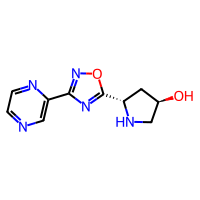
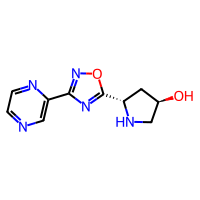
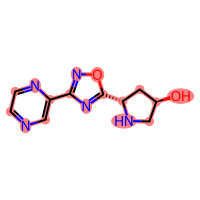
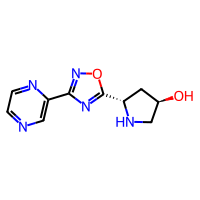
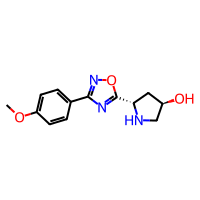
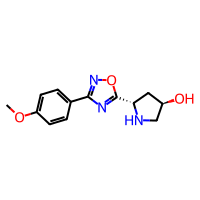
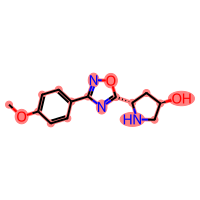
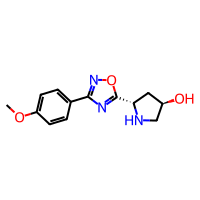
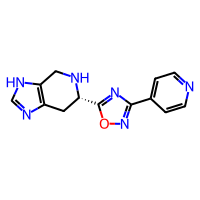
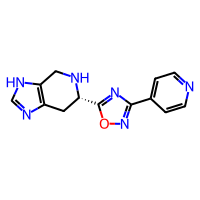
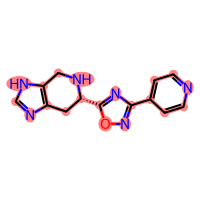
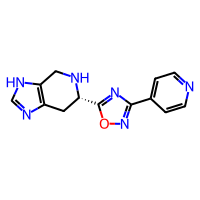
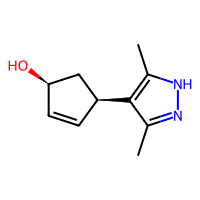
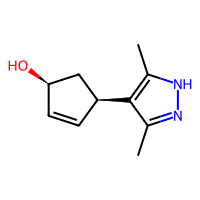
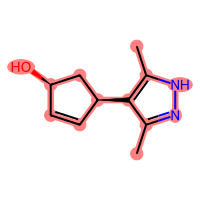
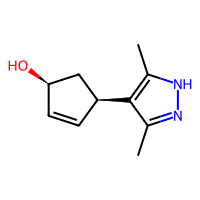
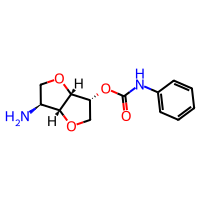
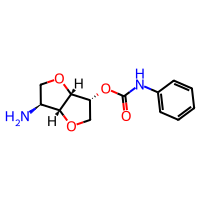
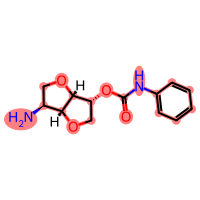
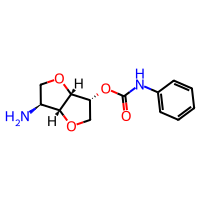
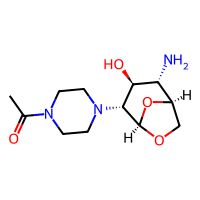
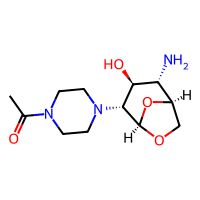
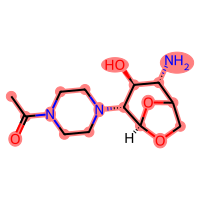
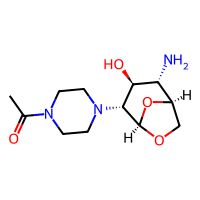
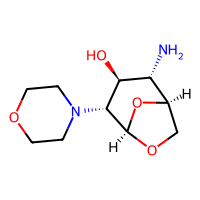
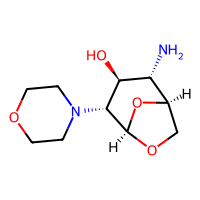
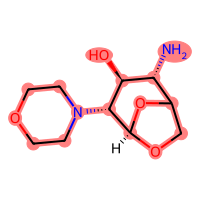
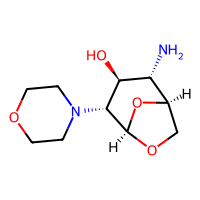
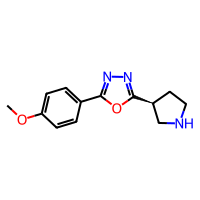
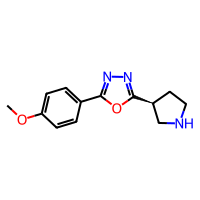
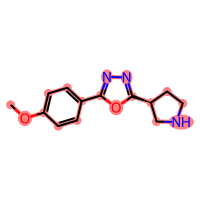
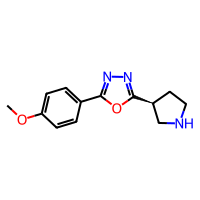
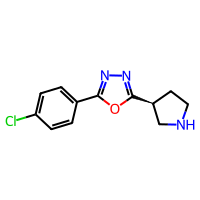
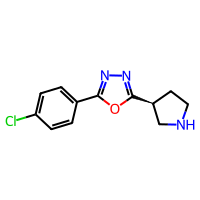
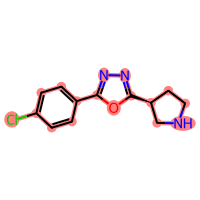
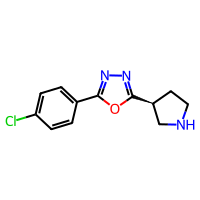
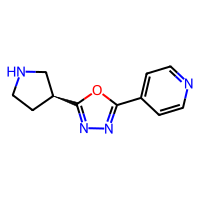
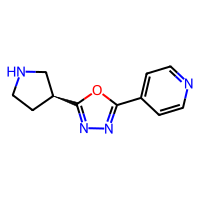
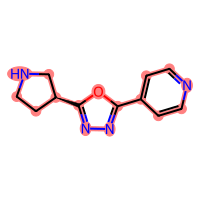
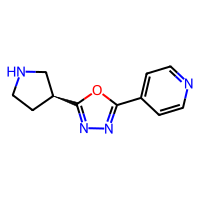
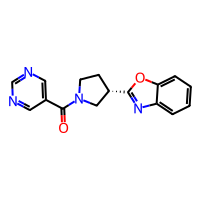
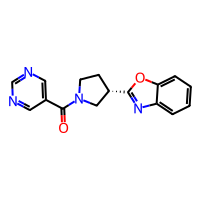
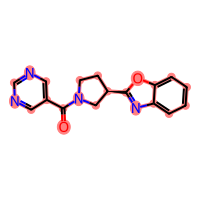
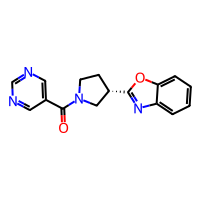
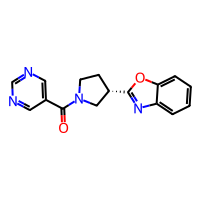
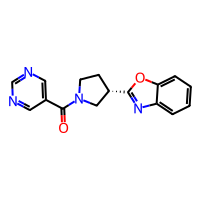
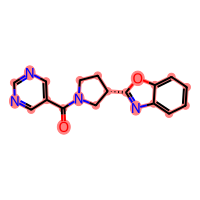
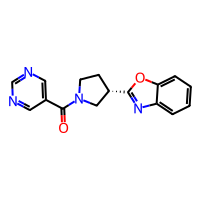
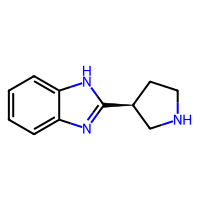
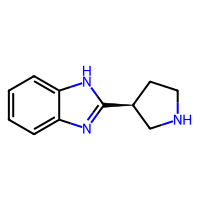
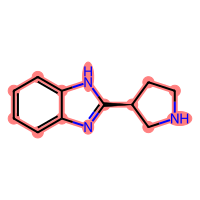
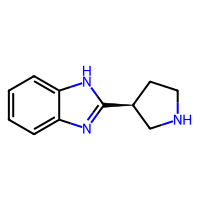
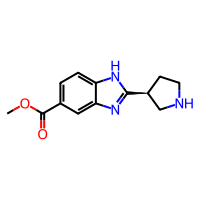
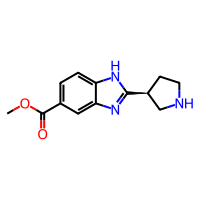
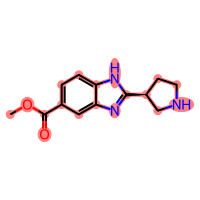
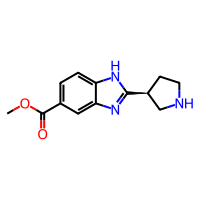
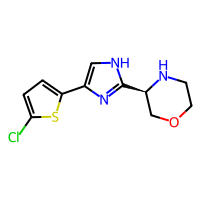
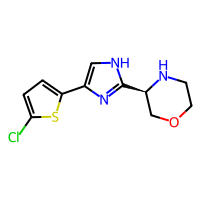
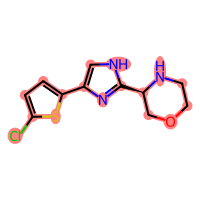
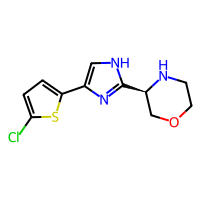
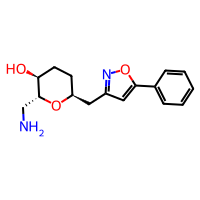
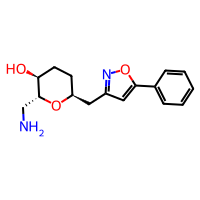
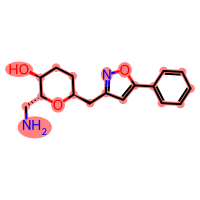
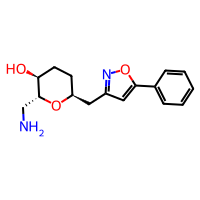
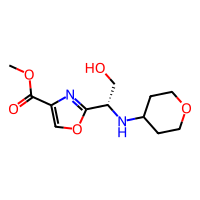
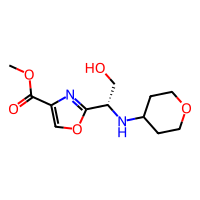
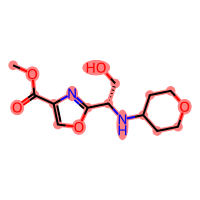
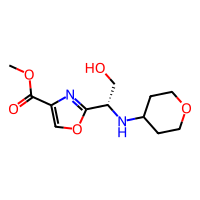
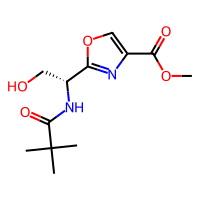
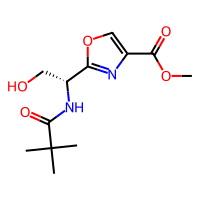
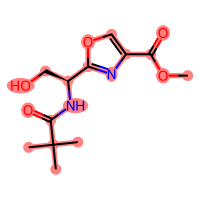
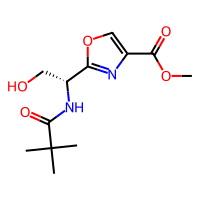
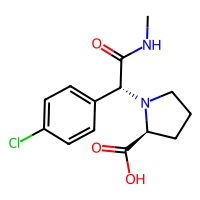
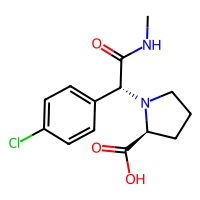
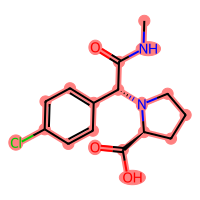
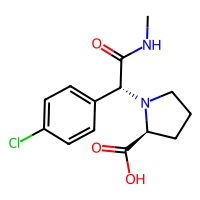
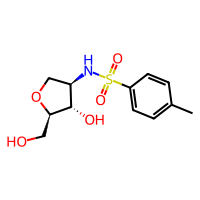
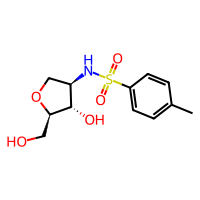
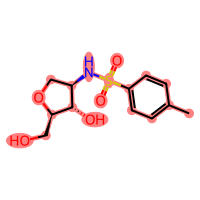
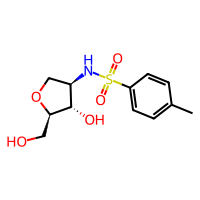
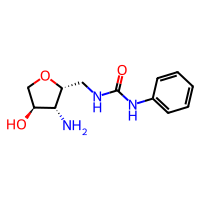
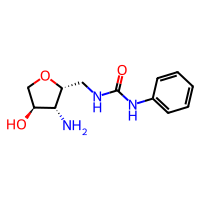
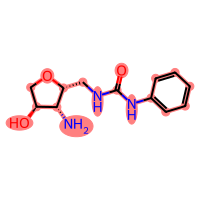
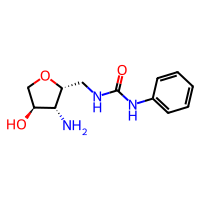
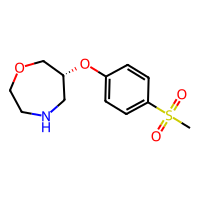
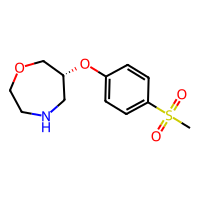
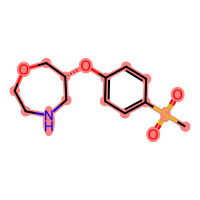
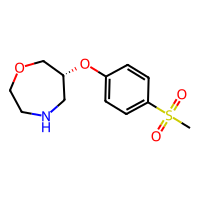
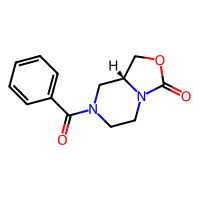
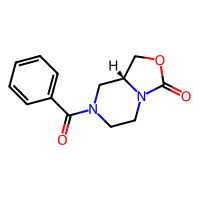
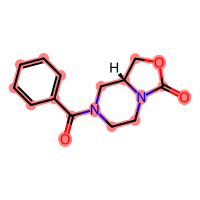
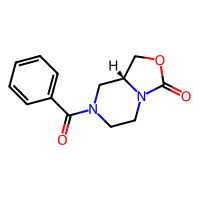
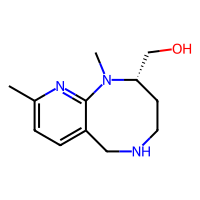
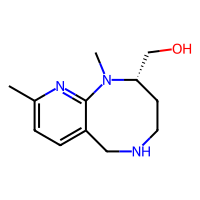
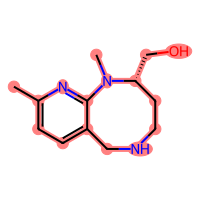
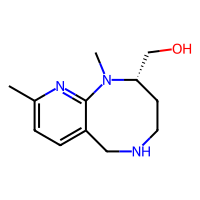
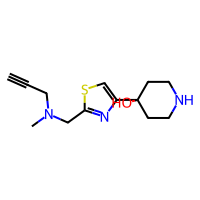
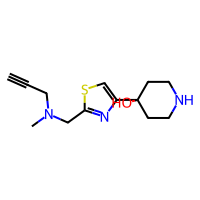
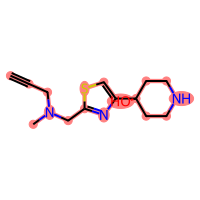
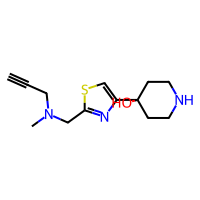
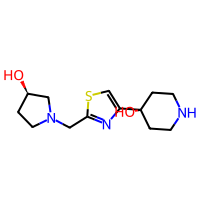
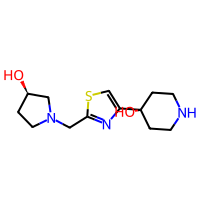
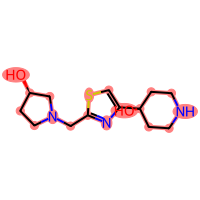
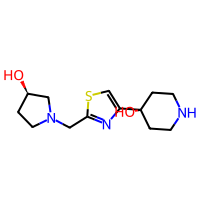
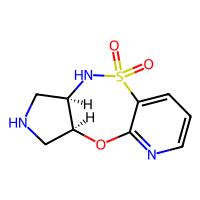
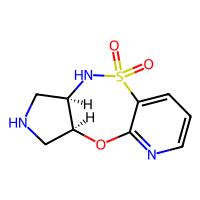
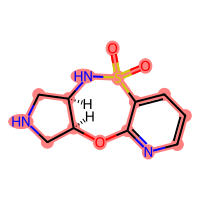
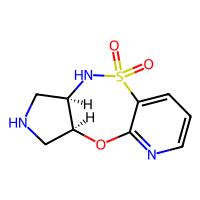
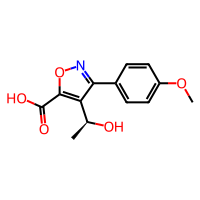
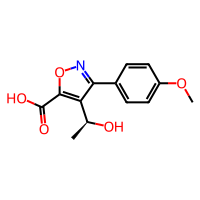
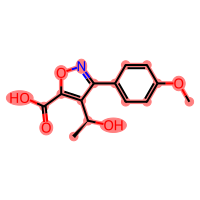
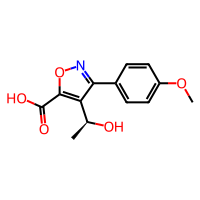
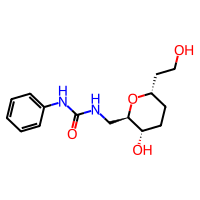
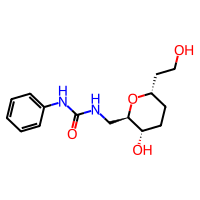
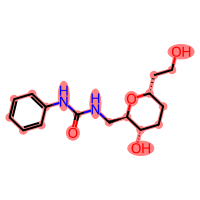
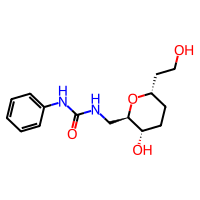
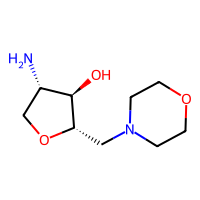
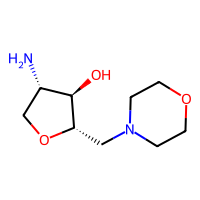
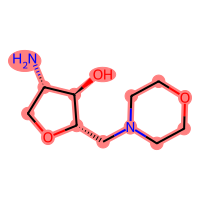
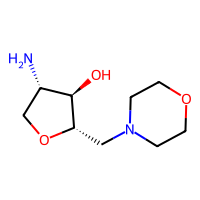
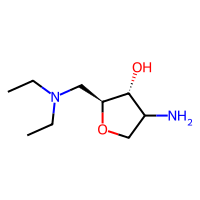
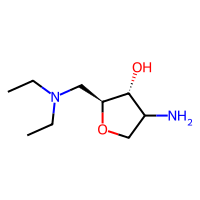
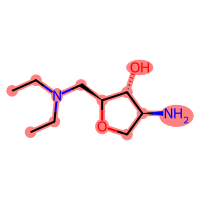
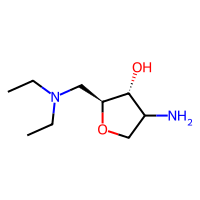
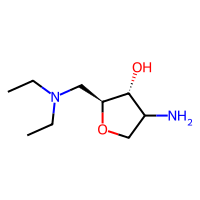
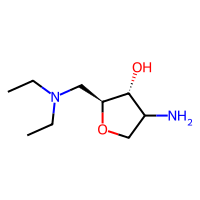
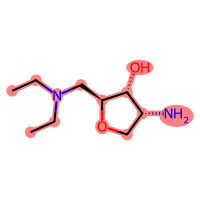
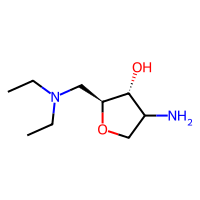
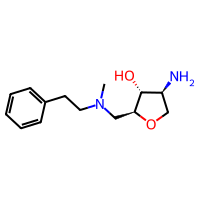
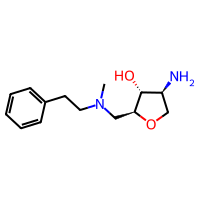
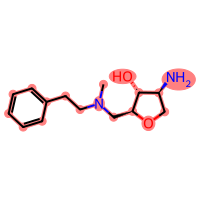
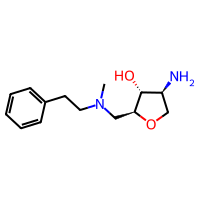

In [8]:
fragments_with_COCONUT_entry_df = NPs_df[NPs_df['Num_Exit_Atoms'] == 0].reset_index(drop=True)
print(len(fragments_with_COCONUT_entry_df))
fragments_with_COCONUT_entry_df.to_csv('Analysis/NPs/Frg_in_the_COCONUT.csv')
fragments_with_COCONUT_entry_df

Unsurprisingly, all the non-fluorinated fragments were found to possess an entry in the COCONUT database themselves, 
as the latter sources molecules from the subset of NPs from ZINC15 database, among others, which in turn integrates the AnalytiCon Discovery NP library.

### Group Fragments

31


,CF_FRG,CF_SMILES,CF_2D_Mol,Substructure_SMILES,Substructure_2D_Mol,Exit_Atom_Numbers,COCONUT_ID,Substructure_Exit_Atoms
0,F005,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,,"[0, 3]","[CNP0410447.1, CNP0025661.1, CNP0475692.1, CNP...",

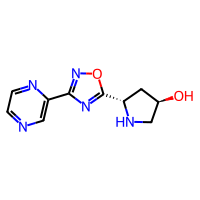
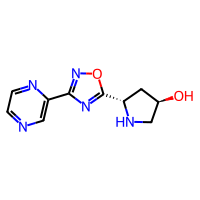
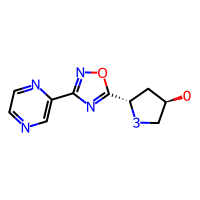

In [9]:
# Group by the fragments
exit_vector_df = NPs_df.groupby('CF_FRG').agg({
    'CF_FRG' : 'first', 
    'CF_SMILES' : 'first', 
    'CF_2D_Mol' : 'first', 
    'Substructure_SMILES': 'first', 
    'Substructure_2D_Mol': 'first',
    'Exit_Atom_Numbers': lambda x: list(set(itertools.chain.from_iterable(x))),  # concatenate the lists of exit vector atom numbers
    'COCONUT_ID': list, 
    }).reset_index(drop=True)

# Visualize the exit vector atoms
exit_vector_df['Substructure_Exit_Atoms'] = exit_vector_df.apply(lambda row: show_exit_atom_numbers(row['Substructure_2D_Mol'], row['Exit_Atom_Numbers']), axis=1)

print(len(exit_vector_df))
exit_vector_df.to_html('Analysis/NPs/Exit_Vectors.html')

exit_vector_df.head(1)

### Add generalized structures

25
25


,CF_FRG,CF_SMILES,CF_2D_Mol,Exit_Atom_Numbers,COCONUT_ID,Substructure_Exit_Atoms,Exit_Vector_SMILES,Exit_Vector_Mol
0,F005,O[C@H]1CN[C@H](c2nc(-c3cnccn3)no2)C1,,"[0, 3]","[CNP0410447.1, CNP0025661.1, CNP0475692.1, CNP...",,*O[C@@H]1C[C@@H](c2nc(-c3cnccn3)no2)N(*)C1,
1,F009,COc1ccc(-c2noc([C@@H]3C[C@@H](O)CN3)n2)cc1,,"[0, 18, 15]","[CNP0107452.1, CNP0106004.1, CNP0013065.1, CNP...",,*COc1ccc(-c2noc([C@@H]3C[C@@H](O)CN3*)n2)cc1*,
2,F012,c1cc(-c2noc([C@@H]3Cc4nc[nH]c4CN3)n2)ccn1,,[15],"[CNP0012247.1, CNP0124972.1, CNP0417260.1, CNP...",,*N1Cc2[nH]cnc2C[C@H]1c1nc(-c2ccncc2)no1,
3,F024,Cc1n[nH]c(C)c1[C@H]1C=C[C@@H](O)C1,,"[3, 2, 11]","[CNP0456041.1, CNP0032030.1, CNP0464053.1, CNP...",,*O[C@H]1C=CC(c2c(C)nn(*)c2C)C1,
4,F030,N[C@H]1CO[C@H]2[C@@H]1OC[C@H]2OC(=O)Nc1ccccc1,,"[0, 15, 16, 17, 18]","[CNP0042954.1, CNP0123493.1, CNP0444709.1, CNP...",,*[NH][C@H]1CO[C@H]2[C@@H]1OC[C@H]2OC(=O)Nc1c(*...,
5,F055,CC(=O)N1CCN([C@H]2[C@@H]3OC[C@@H](O3)[C@@H](N)...,,[14],"[CNP0033754.1, CNP0033766.1, CNP0442270.1, CNP...",,*N[C@@H]1[C@H](O)[C@@H](N2CCN(C(C)=O)CC2)[C@@H...,
6,F058,N[C@H]1[C@H](O)[C@@H](N2CCOCC2)[C@@H]2OC[C@H]1O2,,[0],"[CNP0264997.1, CNP0457038.1, CNP0477545.1, CNP...",,*N[C@H]1[C@H](O)[C@@H](N2CCOCC2)[C@@H]2OC[C@H]1O2,
7,F070,COc1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,,[13],"[CNP0134478.1, CNP0104397.1, CNP0055215.1, CNP...",,*N1CC[C@H](c2nnc(-c3ccc(OC)cc3)o2)C1,
8,F073,Clc1ccc(-c2nnc([C@H]3CCNC3)o2)cc1,,[12],"[CNP0144579.1, CNP0128577.1, CNP0134946.1, CNP...",,*N1CC[C@H](c2nnc(-c3ccc(Cl)cc3)o2)C1,
9,F074,c1cc(-c2nnc([C@H]3CCNC3)o2)ccn1,,[10],"[CNP0403251.1, CNP0014058.1, CNP0145768.1, CNP...",,*N1CC[C@H](c2nnc(-c3ccncc3)o2)C1,

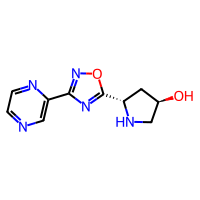
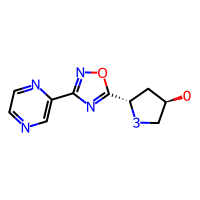
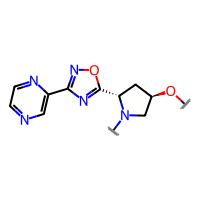
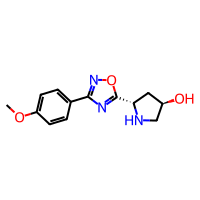
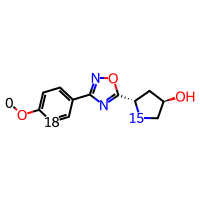
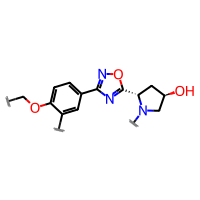
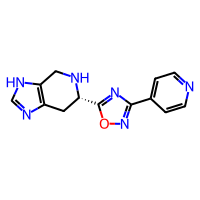
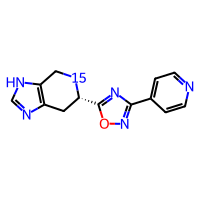
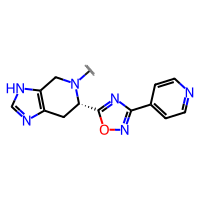
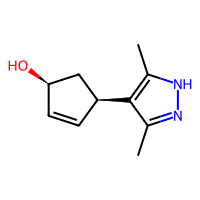
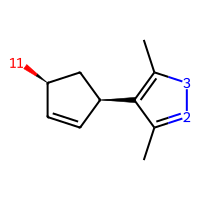
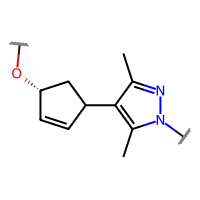
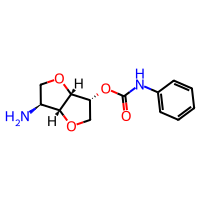
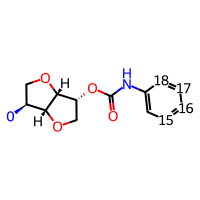
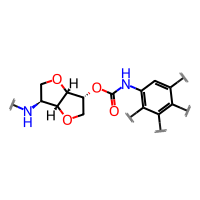
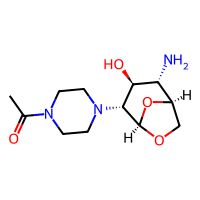
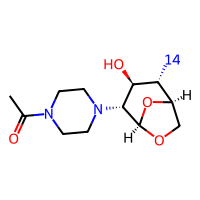
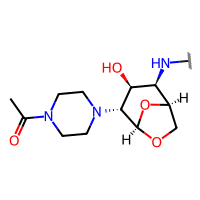
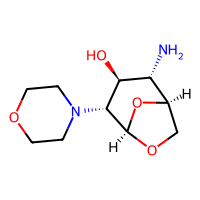
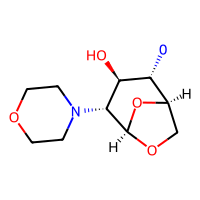
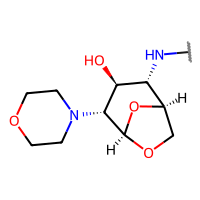
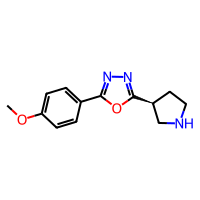
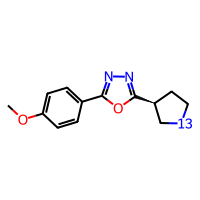
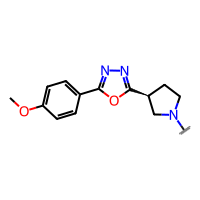
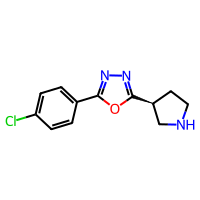
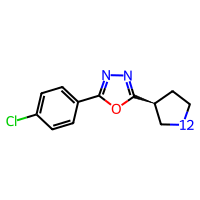
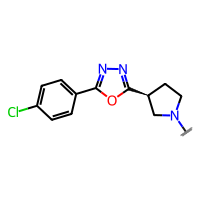
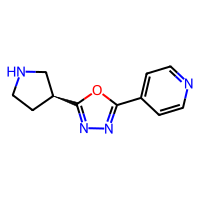
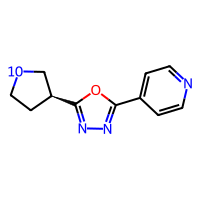
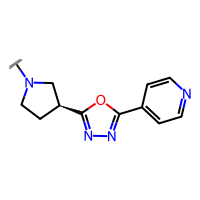
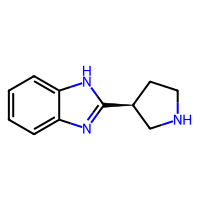
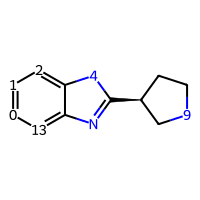
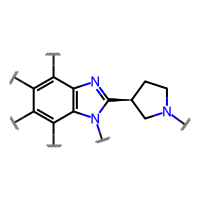
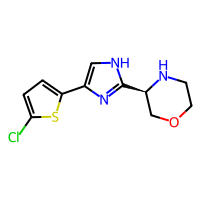
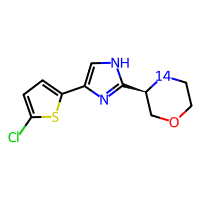
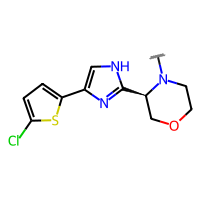
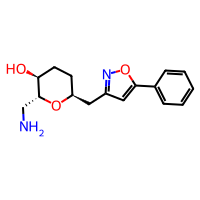
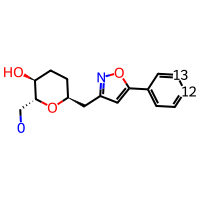
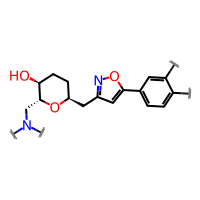
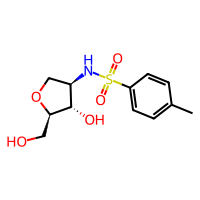
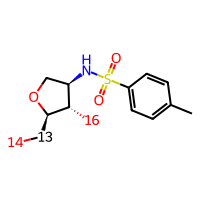
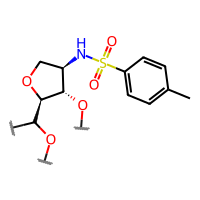
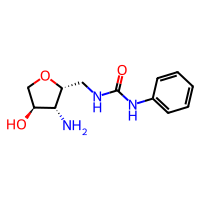
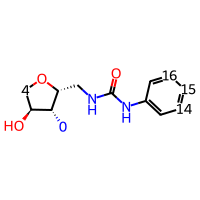
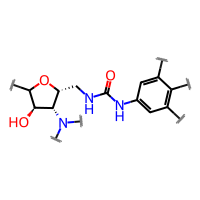
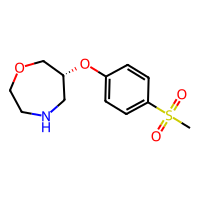
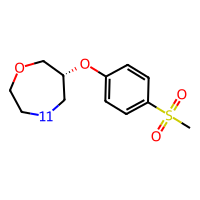
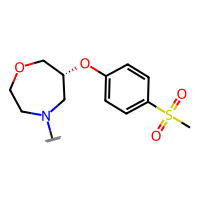
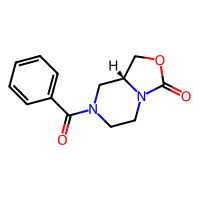
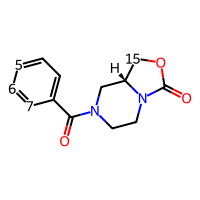
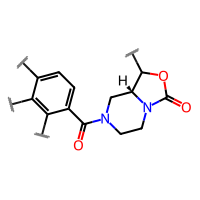
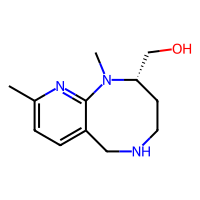
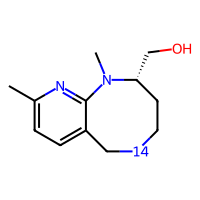
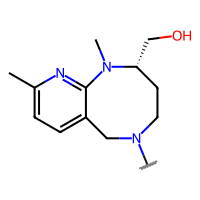
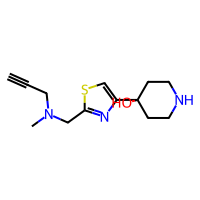
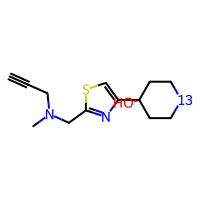
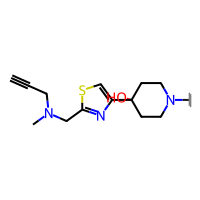
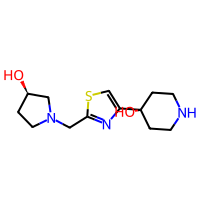
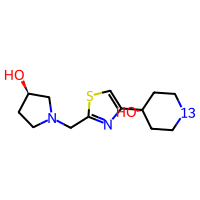
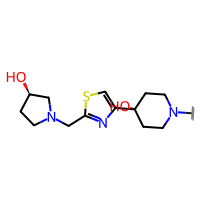
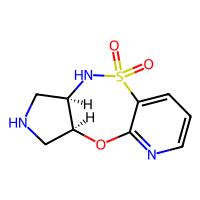
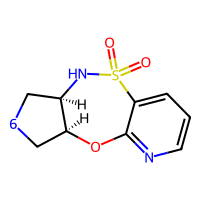
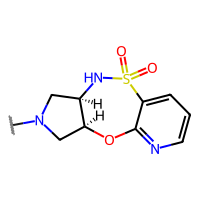
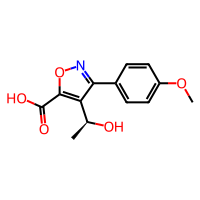
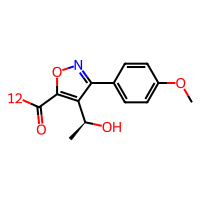
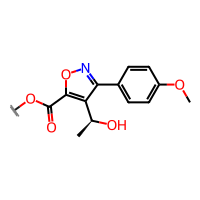
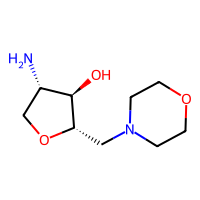
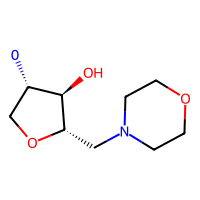
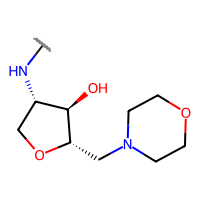
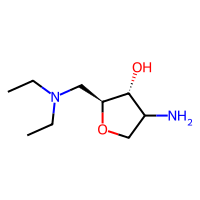
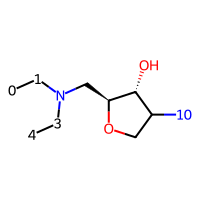
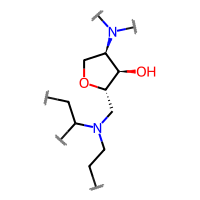
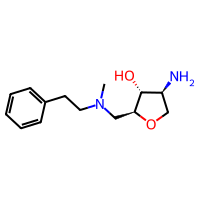
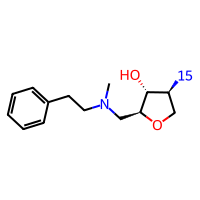
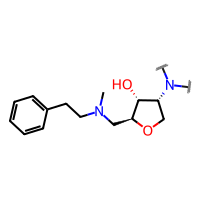

In [10]:
generalized_smiles = pd.DataFrame(
{'CF_FRG':               
['F005', 'F009', 'F012', 'F024', 'F030', 'F055', 'F058', 'F070', 'F073', 'F074', 'F134', 'F145',  
 'F168', 'F189', 'F225', 'F236', 'F248', 'F274', 'F283', 'F294', 'F299', 'F304', 'F312', 'F313', 'F322'], 
 'Exit_Vector_SMILES': 
[ '*O[C@@H]1C[C@@H](c2nc(-c3cnccn3)no2)N(*)C1', # F005 [0, 3]
'*COc1ccc(-c2noc([C@@H]3C[C@@H](O)CN3*)n2)cc1*', # F009 [0, 18, 15]
'*N1Cc2[nH]cnc2C[C@H]1c1nc(-c2ccncc2)no1', # F012 [15]
'*O[C@H]1C=CC(c2c(C)nn(*)c2C)C1', # F024 [3, 2, 11]
'*[NH][C@H]1CO[C@H]2[C@@H]1OC[C@H]2OC(=O)Nc1c(*)c(*)c(*)c(*)c1', # F030 [0, 15, 16, 17, 18] Dual substitution at exit vector 0?
'*N[C@@H]1[C@H](O)[C@@H](N2CCN(C(C)=O)CC2)[C@@H]2OC[C@H]1O2', # F055 [14]
'*N[C@H]1[C@H](O)[C@@H](N2CCOCC2)[C@@H]2OC[C@H]1O2', # F058 [0]
'*N1CC[C@H](c2nnc(-c3ccc(OC)cc3)o2)C1', # F070 [13]
'*N1CC[C@H](c2nnc(-c3ccc(Cl)cc3)o2)C1', # F073 [12]
'*N1CC[C@H](c2nnc(-c3ccncc3)o2)C1', # F074 [10]
# F102 [] No substitution in the COCONUT NP(s).
'*N1CC[C@@H](C1)C1=NC2=C(N1*)C(*)=C(*)C(*)=C2*', # F134 [0, 1, 2, 4, 9, 13]
# F138 [] No substitution in the COCONUT NP(s).
'*N1CCOC[C@H]1c1nc(-c2ccc(Cl)s2)c[nH]1', # F145 [14]
'O[C@H]1CC[C@@H](Cc2cc(on2)-c2ccc(*)c(*)c2)O[C@@H]1CN(*)*', # F168 [0, 12, 13] Dual substitution at exit vector 0.
# F184 [] No substitution in the COCONUT NP(s).
# F186 [] No substitution in the COCONUT NP(s).
# F188 [] No substitution in the COCONUT NP(s).
'Cc1ccc(cc1)S(=O)(=O)N[C@@H]1CO[C@H](C(*)O*)[C@H]1O*', # F189 [16, 13, 14]
'O[C@H]1C(*)O[C@H](CNC(=O)Nc2cc(*)c(*)c(*)c2)[C@@H]1N(*)*', # F225 [0, 4, 14, 15, 16] Dual substitution at exit vector 0.
'*N1CCOC[C@H](Oc2ccc(S(C)(=O)=O)cc2)C1', # F236 [11]
'*C1OC(=O)N2CCN(C[C@H]12)C(=O)c1ccc(*)c(*)c1*', # F248 [7, 5, 6, 15] # Dual substitution at exit vector 15.
'*N1CC[C@@H](CO)N(C)c2nc(C)ccc2C1', # F274 [14]
'*N1CCC(O)(c2csc(CN(C)CC#C)n2)CC1', # F283 [13]
'*N1CCC(O)(c2csc(CN3CC[C@@H](O)C3)n2)CC1', # F294 [13]
'*N1C[C@@H]2Oc3ncccc3S(=O)(=O)N[C@@H]2C1', # F299 [6]
'COc2ccc(c1noc(C(=O)O*)c1[C@H](C)O)cc2', # F304 [12]  
# F310 [] No substitution in the COCONUT NP(s).
'*N[C@H]1CO[C@@H](CN2CCOCC2)[C@@H]1O', # F312 [0] # Single substitution only.
'O[C@H]1[C@H](CN(CC*)C(*)C*)OC[C@H]1N(*)*', # F313 [0, 1, 3, 4, 10] Dual substitution at exit vector 10.
'*N(*)[C@@H]1CO[C@@H](CN(C)CCc2ccccc2)[C@@H]1O', # F322 [15] Dual substitution at exit vector 15.
]})

# Convert to dataframe 
generalized_smiles_df = pd.DataFrame.from_dict(generalized_smiles)
print(len(generalized_smiles_df))

# Merge with the exit_vector_df based on the 'CF_F' column
exit_vector_df = pd.merge(exit_vector_df, generalized_smiles_df, on='CF_FRG', how='inner')
print(len(exit_vector_df))

# Add molecules to dataframe and orientate them uniformly
PandasTools.AddMoleculeColumnToFrame(exit_vector_df, smilesCol="Exit_Vector_SMILES", molCol='Exit_Vector_Mol')
exit_vector_df = orientate_mols(exit_vector_df, scaffold_col = 'CF_2D_Mol',
                        mol_cols = ['CF_2D_Mol', 'Substructure_2D_Mol', 'Substructure_Exit_Atoms', 'Exit_Vector_Mol'])

# Drop columns
exit_vector_df = exit_vector_df.drop(columns=['Substructure_SMILES', 'Substructure_2D_Mol'])

# Save to file
exit_vector_df.to_html('Analysis/NPs/Exit_Vectors.html')

exit_vector_df

### Draw as grid image

In [11]:
fragments = ['F030', 'F134', 'F313']

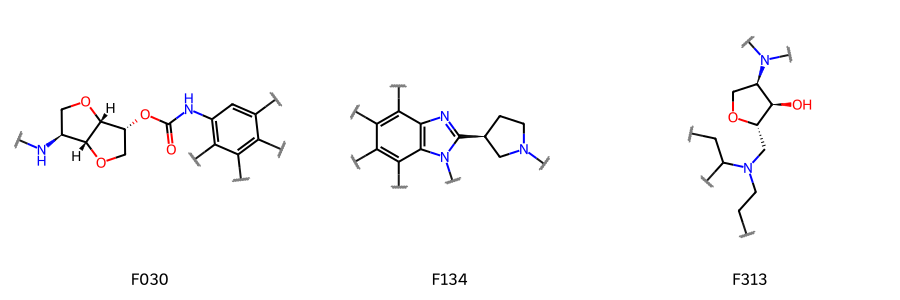

In [12]:
# Grid image of the substitution patterns of the fragments with MORE than 100 associated natural product parents 
rows = exit_vector_df[exit_vector_df['CF_FRG'].isin(fragments)].reset_index(drop=True)

img = Draw.MolsToGridImage(rows['Exit_Vector_Mol'].tolist(), 
                            molsPerRow=3, 
                            subImgSize=(300, 300), 
                            legends=rows['CF_FRG'].tolist()
                            )
display(img)

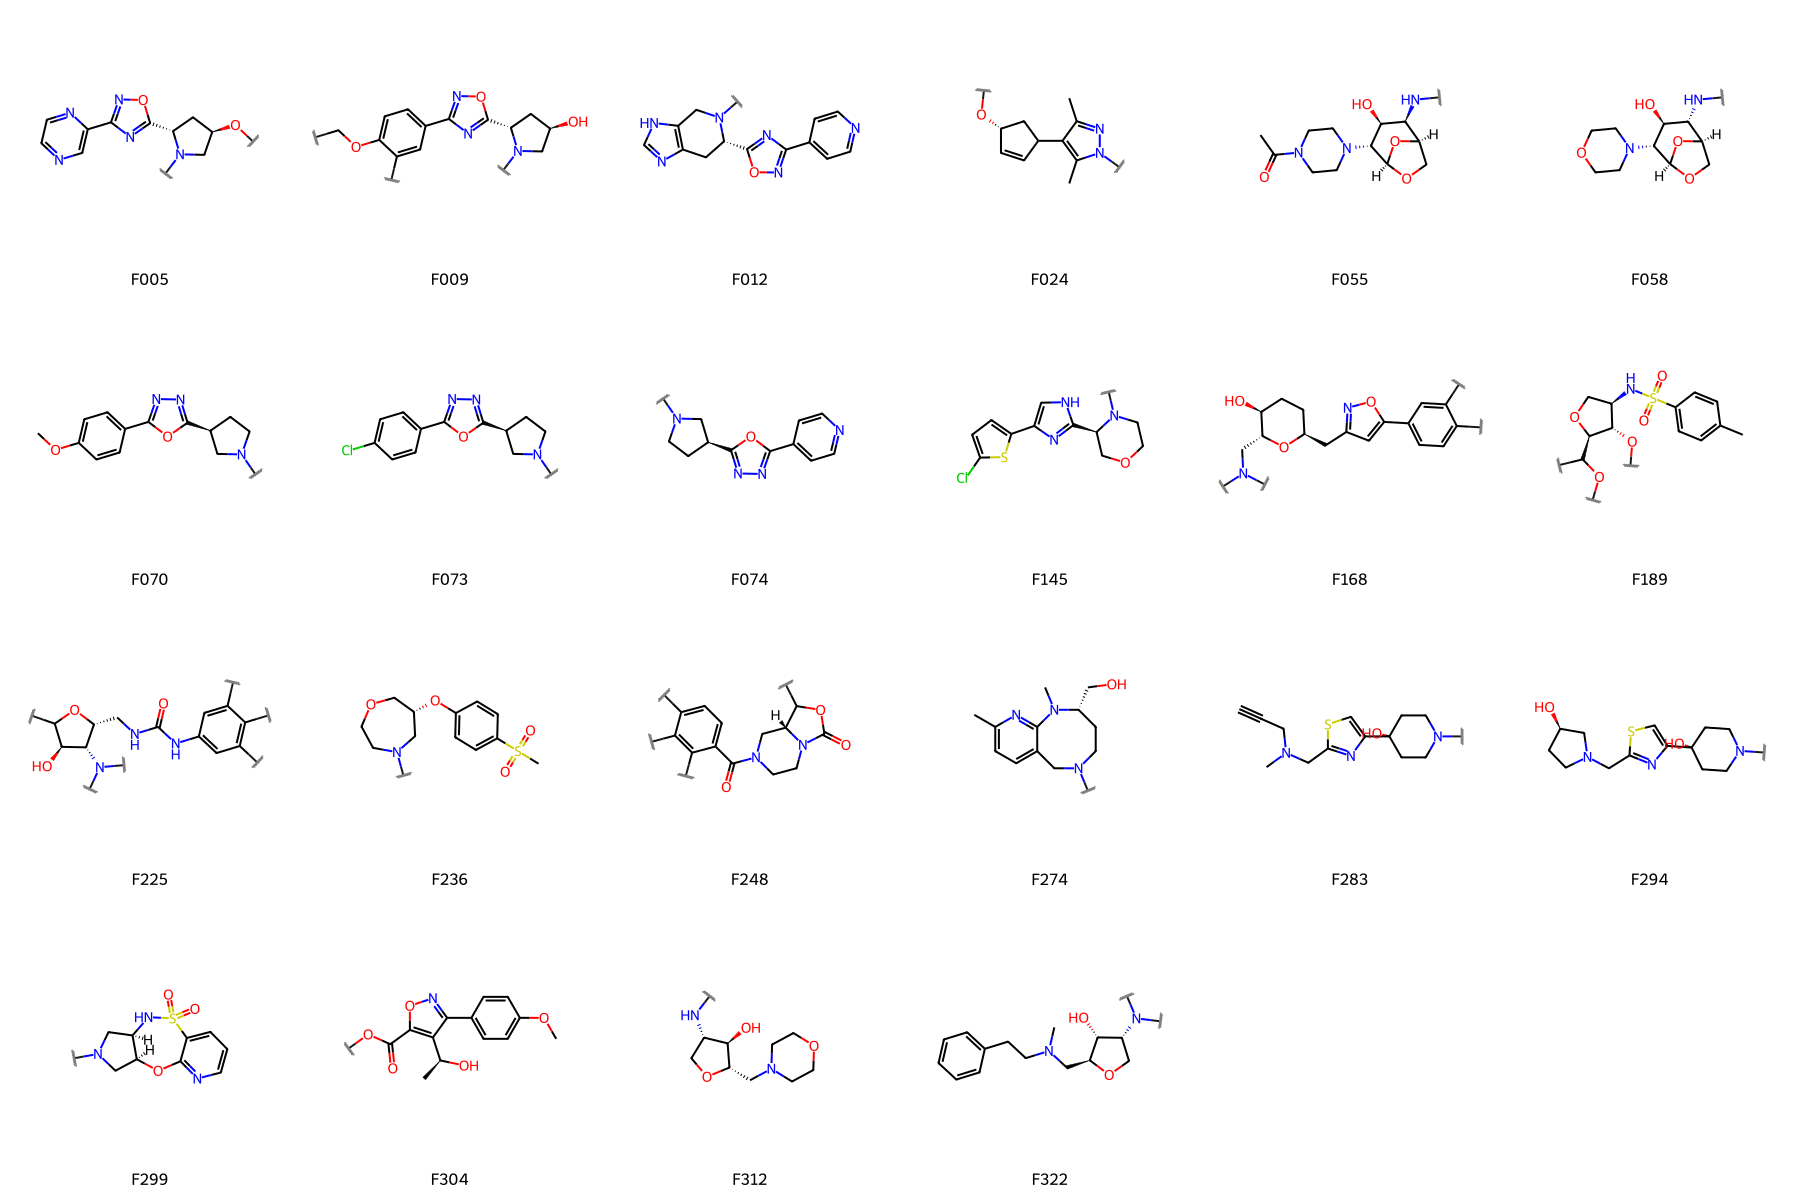

In [13]:
# Grid image of the substitution patterns of the fragments with LESS than 100 associated natural product parents 
rows = exit_vector_df[~exit_vector_df['CF_FRG'].isin(fragments)].reset_index(drop=True)

img = Draw.MolsToGridImage(rows['Exit_Vector_Mol'].tolist(), 
                            molsPerRow=6, 
                            subImgSize=(300, 300), 
                            legends=rows['CF_FRG'].tolist()
                            )

display(img)

# Retrieve more info on the NPs from other databases
## PubChem
### PubChem Compound ID (CID)

In [ ]:
# # SHORT CUT
# NPs_df = pd.read_csv('Analysis/NPs/NPs_with_CF_FRG_substructure.csv')
## NPs_df = NPs_df.loc[65:115,]
# print(len(NPs_df))
# NPs_df.head(1)

In [ ]:
def get_pubchem_info(url):
    response = requests.get(url)    
    if response.status_code == 200:
        return response.json()
    else:
        return None

In [ ]:
def get_pubchem_cid(df, smiles_column): 
    ''' Extract the compound ID (CID) from a PubChem record and return the updated dataframe. '''
    
    # Create a deep copy of df and save it as output_df
    output_df = df.copy(deep=True)
    
    # Define a helper function to extract the CID from a row
    def extract_cid(row, smiles_column): 
        # Extract the SMILES from the row
        smiles = row[smiles_column]

        # Call the get_pubchem_info function to retrieve the record
        base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/"
        record = get_pubchem_info(f"{base_url}{smiles}/cids/JSON")
        
        # If a record is retrieved, extract the cid
        if record:
            cid = str(record['IdentifierList']['CID'][0])
            # Replace any CID = 0 entries by NaN
            if cid == '0': 
                cid = np.NAN
        else: 
            cid = np.NAN   
        return cid

    # Apply the extract_cid function to each row of the dataframe using the apply function
    output_df['PubChem_CID'] = df.apply(extract_cid, axis=1, args=(smiles_column,))

    # Number of CIDs extracted 
    cid_count = output_df['PubChem_CID'].dropna().astype(int).size
    print(f"{cid_count} PubChem IDs were identified.") 

    return output_df

In [ ]:
PubChem_NPs_df = get_pubchem_cid(NPs_df, 'COCONUT_SMILES')

# PubChem_NPs_df.head()

In [ ]:
PubChem_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_PubChem.csv', header=True, index=False)

=> PubChem annotation in the COCONUT database is rather incomplete! 

### PubChem Bioactivities

In [ ]:
def get_pubchem_assay_info(row, cid_column):
    ''' Extract the Target_GI values and Activity Outcomes from a PubChem record. '''
    ''' Takes a row of a pandas dataframe and the name of the Pubchem Compound ID (CID) column as Input '''

    # Extract the CID from the row
    cid = row[cid_column]
    # If the CID column value is NaN or None, skip the next step
    if pd.isna(cid):
        pass
    # Else, convert the CID column value to integer
    else: 
        cid = int(cid)
           
    # Call the get_pubchem_info function to retrieve the record
    record = get_pubchem_info(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/assaysummary/JSON") if cid is not None else None
    
    # Initialize variables
    target_gi = []
    activity_outcome = []
    activity_value = []
    current_targetgi = None
    current_activity_outcome = None
    current_activity_name = None
    current_activity_value = None

    # If the record is retrieved
    if record:
    
        # Extract the columns and rows from the record
        columns = record['Table']['Columns']['Column']
        rows = record['Table']['Row']
        
        # Find the index of the 'Target GI' column and the 'Activity Outcome' column
        targetgi_loc = columns.index('Target GI')
        activity_loc = columns.index('Activity Outcome')
        activity_value_loc = columns.index('Activity Value [uM]')
        activity_name_loc  = columns.index('Activity Name')
        
        # Extract the values from the rows 
        for i in rows: 
            current_targetgi = str(i['Cell'][targetgi_loc])
            # Retrieve the activity values, if a target is associated
            if current_targetgi != "": 
                current_activity_outcome = str(i['Cell'][activity_loc])
                # Exclude any "Inactive" or uncertain results
                if current_activity_outcome not in ["Inactive", "Inconclusive", "Unspecified"]: 
                    # Add the values to the respective lists
                    target_gi.append(current_targetgi)
                    activity_outcome.append(current_activity_outcome)
                    # Also retrieve further information: activity name and value
                    # If the activity type is "Potency"
                    current_activity_name = str(i['Cell'][activity_name_loc])
                    if current_activity_name == "Potency": 
                        # Add the corresponding potency value to the activity_value list
                        current_activity_value = str(i['Cell'][activity_value_loc])
                        activity_value.append(current_activity_value)
                    else: 
                        activity_value.append('NaN')

    # Save lists to new columns
    row['PubChem_Target_GI'] = target_gi
    row['PubChem_Target_Activity_Outcome'] = activity_outcome 
    row['PubChem_Target_Potency_in_uM'] = activity_value

    return row

In [ ]:
# Apply the get_assay_info function to each row of the dataframe using the apply function
PubChem_NPs_df = PubChem_NPs_df.apply(get_pubchem_assay_info, axis=1, cid_column='PubChem_CID')

PubChem_NPs_df.head(1)

In [ ]:
# Explode the lists to individual rows
PubChem_NPs_df = PubChem_NPs_df.explode(['PubChem_Target_GI', 'PubChem_Target_Activity_Outcome', 'PubChem_Target_Potency_in_uM']).reset_index(drop=True)

In [ ]:
PubChem_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_PubChem.csv', header=True, index=False)

### PubChem Target Information

In [ ]:
def get_pubchem_target_info(row, target_gi_column):
    ''' Extract the Target Name and EC Number from a PubChem record. '''
    ''' Takes a row of a pandas dataframe and the name of the Target GI column as input '''

    # Extract the GI number from the first row of the column
    gi = row[target_gi_column] 
        
    # If a GI number was given, get the PubChem record 
    # If the target_gi column value is NaN or None, return None immediately
    record = get_pubchem_info(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/protein/gi/{gi}/summary/JSON") if gi is not None else None

    # If the record exists
    if record:
        # Extract the protein summary from the record
        record_row = record['ProteinSummaries']['ProteinSummary']

        # Extract the target name from the protein summary, excluding empty entries
        targetname = [i['Name'] for i in record_row if i['Name'] != ""]
        # If targetname is a list of length 1, flatten to the value itself
        targetname = targetname[0] if isinstance(targetname, list) and len(targetname) == 1 else targetname

        # Extract the target synonyms from the protein summary, excluding empty entries
        # Extract only those, for which the substring 'EC' is contained in the string
        synonym = [subitem for item in [i['Synonym'] for i in record_row if 'Synonym' in i] for subitem in (item if isinstance(item, list) else [item]) if 'EC' in subitem]
        # Remove any letters and spaces from every item in the synonym list
        synonym = [re.sub(r'[A-Za-z ]+', '', item) for item in synonym]
        # If synonym is a list of length 1, flatten to the value itself; for empty lists have a NaN
        synonym = synonym[0] if isinstance(synonym, list) and len(synonym) == 1 else None if isinstance(synonym, list) and len(synonym) == 0 else synonym

        row['PubChem_Target_Name']      = targetname
        row['PubChem_Target_EC_Number'] = synonym

    else: 
        row['PubChem_Target_Name']      = np.NAN
        row['PubChem_Target_EC_Number'] = np.NAN

    return row

In [ ]:
# Apply the function to the 'Target_GI' column of the dataframe
PubChem_NPs_df = PubChem_NPs_df.apply(get_pubchem_target_info, axis=1, target_gi_column='PubChem_Target_GI')

PubChem_NPs_df.head(1)

In [ ]:
# Save to file
PubChem_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_PubChem.csv', header=True, index=False)

In [ ]:
# SHORT-CUT 
# PubChem_NPs_df = pd.read_csv('Analysis/NPs/NP_Data_from_PubChem.csv')

### Analysis

In [ ]:
# Show only the rows of the NPs_df, for which a target was annotated in PubChem
pubchem_target_annotations = PubChem_NPs_df[PubChem_NPs_df['PubChem_Target_Name'].notna()].reset_index(drop=True)

# Drop duplicates, ignoring the activity value column
subset = ['CF_FRG', 'COCONUT_ID', 'PubChem_CID', 'PubChem_Target_GI', 'PubChem_Target_Activity_Outcome']
pubchem_target_annotations = pubchem_target_annotations.drop_duplicates(subset=subset)

print(f"Total number of target annotations in PubChem = {len(pubchem_target_annotations)}")
print(f"for {len(pubchem_target_annotations['COCONUT_ID'].unique())} NPs. \n")

print(f"Covering {len(pubchem_target_annotations['PubChem_Target_Name'].unique())} different target(s) =") 
print(f"{pubchem_target_annotations['PubChem_Target_Name'].value_counts()} \n")

**Annotated Targets are**: 
- Interleukin-1 receptor-like 1 Chain B
- Polyunsaturated fatty acid lipoxygenase ALOX12
- atrial natriuretic peptide receptor 1 precursor
- atrial natriuretic peptide receptor 2 precursor
- Alanine aminotransferase 2
- Ubiquitin carboxyl-terminal hydrolase 8 
- Catechol O-methyltransferase
- Phenylethanolamine N-methyltransferase
- Nicotinamide N-methyltransferase 
- Histamine N-methyltransferase
- Guanidinoacetate N-methyltransferase 
- Glycine N-methyltransferase
- Inositol hexakisphosphate kinase 1 (IP6K1)

In [ ]:
# Show the rows for the IP6K1 
ip6k1 = PubChem_NPs_df[PubChem_NPs_df['PubChem_Target_Name'] == 'Inositol hexakisphosphate kinase 1']

print(f"The NPs with the COCONUT IDs {ip6k1['COCONUT_ID'].unique()}")
print(f"/ PubChem CID {ip6k1['PubChem_CID'].unique()} are annotated to be active towards IP6K1.")
print(f"The underlying CrystalsFirst Fragments are = {ip6k1['CF_FRG'].unique()}")


In [ ]:
PandasTools.RenderImagesInAllDataFrames(images=True)
ip6k1

## ChEMBL

### ChEMBL Molecule IDs 

In [ ]:
from chembl_webresource_client.new_client import new_client

# inspired by https://notebooks.gesis.org/binder/jupyter/user/chembl-chembl_webresource_client-yml6qnof/notebooks/demo_wrc.ipynb

def chembl_similarity_query(smiles, similarity_threshold):
    """
    Helper function to get the similarity query result from the ChEMBL API.
    
    Parameters:
    smiles (str):               The SMILES string of the molecule.
    similarity_threshold (int): The similarity threshold for the query.
    
    Returns:                    The query result from the ChEMBL API.
    """
    similarity = new_client.similarity

    return similarity.filter(smiles=smiles, similarity=similarity_threshold
                        ).only(['molecule_chembl_id', 'similarity', 'pref_name'])


def get_chembl_molecule_id(df, SMILES_col, similarity_threshold):
    """
    
    Parameters:
    df (DataFrame):             The DataFrame containing the SMILES.
    SMILES_col (str):           The column in the df, comprising the SMILES.
    similarity_threshold (int): The similarity threshold for the query.
    
    Returns:
    dict: A dictionary with the SMILES as keys and the similarity query results as values.
    """
    chembl_dict = {}
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        smiles = row[SMILES_col]
        query_result = chembl_similarity_query(smiles, similarity_threshold)
        
        if query_result:
            chembl_dict[smiles] = query_result
    
     # Convert the dictionary into a DataFrame
    output_df = pd.DataFrame.from_dict(chembl_dict, orient='index')

    # Apply a lambda function to remove None values from each row
    output_df['ChEMBL_API'] = output_df.apply(lambda row: [val for val in row if val is not None], axis=1)

    # Save the index to a new column, and rename the latter 
    output_df = output_df.reset_index(drop=False).rename(columns={'index': SMILES_col})

    # Extract the value corresponding to the molecule_chembl_id key from the ChEMBL_API column 
    output_df[f'ChEMBL_ID_Similarity{similarity_threshold}'] = output_df['ChEMBL_API'].apply(lambda x: [d['molecule_chembl_id'] for d in x] if isinstance(x, list) else [x['molecule_chembl_id']] if isinstance(x, dict) else None)

    # Convert all entries in the 'ChEMBL_ID_Similarity' column that are a list of length 1 into simple values
    output_df[f'ChEMBL_ID_Similarity{similarity_threshold}'] = output_df[f'ChEMBL_ID_Similarity{similarity_threshold}'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

    # Keep only the two column specified
    output_df = output_df[[SMILES_col, f'ChEMBL_ID_Similarity{similarity_threshold}']]  

    # Rename column
    output_df.rename(columns={f'ChEMBL_ID_Similarity{similarity_threshold}': 'ChEMBL_Molecule_ID'}, inplace=True)

    print(f"{len(output_df)} ChEMBL molecule IDs were identified.")

    # Merge with the input df, based on the SMILES_col
    return pd.merge(df, output_df, on=SMILES_col, how='outer')

similarity_threshold = 100

In [ ]:
# Call the exploit_ChEMBL_API function
ChEMBL_NPs_df = get_chembl_molecule_id(NPs_df, 'COCONUT_SMILES', similarity_threshold)

ChEMBL_NPs_df.head()

In [ ]:
# Cross-Check: Show rows, for which NPs multiple ChEMBL IDs have been identified based on the COCONUT NP SMILES 
ChEMBL_NPs_df[ChEMBL_NPs_df['ChEMBL_Molecule_ID'].apply(lambda x: isinstance(x, list))]

In [ ]:
# Convert the datatype of the values in the ChEMBL_Molecule_ID column to strings
ChEMBL_NPs_df['ChEMBL_Molecule_ID'] = ChEMBL_NPs_df['ChEMBL_Molecule_ID'].astype(str)

In [ ]:
ChEMBL_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_ChEMBL.csv', header=True, index=False)

### ChEMBL Bioactivities

In [ ]:
def get_chembl_bioactivities(df, molecule_id_col):
    """
    Get bioactivities for each compound in the input DataFrame.

    Parameters:
    - df (pandas DataFrame): Input DataFrame containing the compounds
    - molecule_id_col (str): Column name in the input DataFrame containing the ChEMBL molecule IDs

    """

    # Create a new bioactivities API client
    bioactivities_api = new_client.activity

    # Initialize an empty list to store the bioactivity data for each compound
    bioactivity_list = []

    # Get the bioactivities for the current compound using the ChEMBL molecule ID
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        bioactivities = bioactivities_api.get(molecule_chembl_id=row[molecule_id_col]).only(
                "molecule_chembl_id",
                "activity_id", "assay_chembl_id", "assay_type",
                # "assay_description",  "type", "target_organism",
                "standard_units", "relation", "standard_value", "pchembl_value",
                "target_chembl_id", "comment", #"activity_comment"
            )

        # Create a dataframe from the retrieved info
        bioactivities_df = pd.DataFrame.from_records(bioactivities)
        bioactivity_list.append(bioactivities_df)

    bioactivity_df = pd.concat(bioactivity_list, ignore_index=True)

    # Drop duplicates and reset index
    bioactivity_df.drop_duplicates(keep="first", inplace=True)
    bioactivity_df.reset_index(inplace=True, drop=True)

    # Rename columns
    bioactivity_df.rename(columns={
        'molecule_chembl_id':  molecule_id_col, 
        'target_chembl_id' :   'ChEMBL_Target_ID',
        'relation':            'ChEMBL_Relation', 
        'assay_chembl_id':     'ChEMBL_Assay_ID', 
        'activity_id':         'ChEMBL_Activity_ID', 
        'standard_units':      'ChEMBL_Standard_Unit', 
        'standard_value':      'ChEMBL_Standard_Value',
        'pchembl_value':       'pChEMBL_Value', 
        'type':                'ChEMBL_Value_Type', 
        'assay_type':          'ChEMBL_Assay_Type', 
        'activity_comment':    'Activity_Comment'
    }, inplace=True)

    print(len(bioactivity_df), "Bioactivity values were found in total.")

    # Merge with the input df, based on the SMILES_col
    return pd.merge(df, bioactivity_df, on=molecule_id_col, how='outer')

(See Krzyzanowski 2023)
*  pChEMBL value = -log(molar IC50, XC50, EC50, AC50, Ki, Kd or Potency)
* Classification of COCONUT_SMILESs by activity: low (pChEMBL ≤ 5.3), medium (5.3 < pChEMBL ≤ 6.5), high (6.5 ≤ pChEMBL)
* Assay confidence score: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-the-confidence-score is available for the assay API 

In [ ]:
# Apply the function
ChEMBL_NPs_df = get_chembl_bioactivities(ChEMBL_NPs_df, 'ChEMBL_Molecule_ID')

In [ ]:
# Keep only data from binding assays
# Binding (B) - Data measuring binding of compound to a molecular target, e.g. Ki, IC50, Kd.
# Other assay types are: Functional/Phenotypic (F), ADME (A), Toxicity (T), Physicochemical (P), Unclassified (U) 
print("Assay Types found:", ChEMBL_NPs_df["ChEMBL_Assay_Type"].unique())
ChEMBL_NPs_df = ChEMBL_NPs_df[ChEMBL_NPs_df['ChEMBL_Assay_Type'].isin(['B', 'F'])]
print("Number of Bioactivity values after filtering for the assay type (= B[inding] or F[unctional]/Phenotypic):", len(ChEMBL_NPs_df), "\n")

In [ ]:
ChEMBL_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_ChEMBL.csv', header=True, index=False)

In [ ]:
# Which target IDs have been annotated?
ChEMBL_target_annotations = ChEMBL_NPs_df["ChEMBL_Target_ID"].unique()
print(f"{len(ChEMBL_target_annotations)} different targets were annotated in functional and binding assays, namely {ChEMBL_target_annotations} \n ")

# ChEMBL_NPs_df

### ChEMBL Assay Details

In [ ]:
def get_chembl_assay_info(df, assay_id_col):
    """
    Retrieves more information on the assay from the ChEMBL via API.

    Parameters:
    - df (pandas DataFrame):  Input DataFrame containing the ChEMBL assay IDs.
    - assay_id_col (str):     Column name in the input DataFrame containing the ChEMBL assay IDs.
    """

    # Create a new assay API client
    assay_api = new_client.assay

    # Get more information for the current ChEMBL assay ID 
    assay_info = assay_api.get(assay_chembl_id=list(df[assay_id_col])).only(
        "assay_chembl_id", "confidence_score", "confidence_description", "description") 

    # Create a dataframe from the retrieved info
    assay_df = pd.DataFrame.from_records(list(tqdm(assay_info)))

    # Drop duplicates and reset index
    assay_df.drop_duplicates(keep="first", inplace=True)
    assay_df.reset_index(drop=True, inplace=True)

    # Rename columns
    assay_df.rename(columns={
        'assay_chembl_id'        :  assay_id_col,
        'confidence_score'       : 'ChEMBL_Assay_Confidence_Score',
        'confidence_description' : 'ChEMBL_Assay_Confidence_Description',
        'description'            : 'ChEMBL_Assay_Description'
        }, inplace=True)

    # Merge with the input df, based on the target_id_col and return the merge DataFrame
    return pd.merge(df, assay_df, on=assay_id_col, how='outer')

In [ ]:
# Apply the function
ChEMBL_NPs_df = get_chembl_assay_info(ChEMBL_NPs_df, 'ChEMBL_Assay_ID')

In [ ]:
ChEMBL_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_ChEMBL.csv', header=True, index=False)

### ChEMBL Target Information

In [ ]:
def get_chembl_target_info(df, target_id_col):
    """
    Retrieves more information on the target from the ChEMBL via API.

    Parameters:
    - df (pandas DataFrame):  Input DataFrame containing the ChEMBL target IDs.
    - target_id_col (str):    Column name in the input DataFrame containing the ChEMBL target IDs.
    """

    # Create a new target API client
    targets_api = new_client.target

    # Get more target information for the current ChEMBL target ID 
    target_info = targets_api.get(
            target_chembl_id=list(df[target_id_col]), 
        ).only("target_chembl_id", "pref_name", "target_type", "organism") 

    # Create a dataframe from the retrieved info
    target_df = pd.DataFrame.from_records(list(tqdm(target_info)))

    # Drop duplicates and reset index
    target_df.drop_duplicates(keep="first", inplace=True)
    target_df.reset_index(drop=True, inplace=True)

    # Rename columns
    target_df.rename(columns={
        'target_chembl_id' : target_id_col,
        'pref_name': 'ChEMBL_Target_Name', 
        'target_type' : 'ChEMBL_Target_Type', 
        'organism': 'ChEMBL_Target_Organism'}, inplace=True)

    # Merge with the input df, based on the target_id_col and return the merge DataFrame
    return pd.merge(df, target_df, on=target_id_col, how='outer')

In [ ]:
ChEMBL_NPs_df = get_chembl_target_info(ChEMBL_NPs_df, 'ChEMBL_Target_ID')

In [ ]:
ChEMBL_NPs_df.to_csv(f'Analysis/NPs/NP_Data_from_ChEMBL.csv', header=True, index=False)

In [ ]:
# # Short-Cut
# ChEMBL_NPs_df = pd.read_csv('Analysis/NPs/NP_Data_from_ChEMBL.csv')

### Analysis

In [ ]:
# Keep only the rows, for which the values in the column are not NaN
ChEMBL_NPs_df_filtered = ChEMBL_NPs_df[ChEMBL_NPs_df['ChEMBL_Target_Name'].notna()]

print(f"Target types found: {ChEMBL_NPs_df_filtered['ChEMBL_Target_Type'].unique()}.\n")
print("Keep only data for single proteins and protein complexes:")
# Keep only data for single proteins and protein complexes
# Other target types are, e.g.: Protein Families, Protein Complexes, Protein Nucleic Acid Complex, Selectivity Group, 
#                               Chimeric Protein, Protein Complex Group,  Nucleic Acid, Organism, Tissue, Cell Line, etc.
ChEMBL_NPs_df_filtered = ChEMBL_NPs_df_filtered[  (ChEMBL_NPs_df_filtered['ChEMBL_Target_Type'] == 'SINGLE PROTEIN') 
                                                | (ChEMBL_NPs_df_filtered['ChEMBL_Target_Type'] == 'PROTEIN COMPLEX')]

print(f"{len(ChEMBL_NPs_df_filtered)} bioactivity values are reported overall.")

ChEMBL_NPs_df_filtered.sort_values(by=["CF_FRG", "COCONUT_ID", "ChEMBL_Target_Name", "ChEMBL_Value_Type"]).reset_index(drop=True, inplace=True)

ChEMBL_NPs_df_filtered.to_csv(f'Analysis/NPs/NP_Data_from_ChEMBL.csv', header=True, index=False)

**Print some "statistics"**

In [ ]:
# Drop duplicates, ignoring the activity value column
subset = ['CF_FRG', 'COCONUT_ID', 'ChEMBL_Molecule_ID', 'ChEMBL_Target_ID', 'ChEMBL_Target_Name', 'ChEMBL_Target_Type']
ChEMBL_NPs_df_filtered = ChEMBL_NPs_df_filtered.drop_duplicates(subset=subset) 

print(f"{len(ChEMBL_NPs_df_filtered)} target annotations in ChEMBL")
print(f"For {len(ChEMBL_NPs_df_filtered['COCONUT_ID'].unique())} NPs. \n")

print(f"Covering {len(ChEMBL_NPs_df_filtered['ChEMBL_Target_Name'].unique())} distinct target(s) =") 
print(f"{ChEMBL_NPs_df_filtered['ChEMBL_Target_Name'].value_counts()} \n")

print((ChEMBL_NPs_df_filtered['ChEMBL_Target_Organism'].value_counts())) 

print(f"\n Assay Confidence Scores are: {sorted(list(set(ChEMBL_NPs_df_filtered['ChEMBL_Assay_Confidence_Score'].unique())))}") 

**Assay Confidence Score** <br>
https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-the-confidence-score
| CONFIDENCE_SCORE | DESCRIPTION                                                                 |
|------------------|-----------------------------------------------------------------------------|
| 0                | Default value - Target assignment has yet to be curated                     |
| 1                | Target assigned is non-molecular                                            |
| 3                | Target assigned is molecular non-protein target                             |
| 4                | Multiple homologous protein targets may be assigned (e.g. a PROTEIN FAMILY) |
| 5                | Multiple direct protein targets may be assigned (e.g. a PROTEIN FAMILY)     |
| 6                | Homologous protein complex subunits assigned                                |
| 7                | Direct protein complex subunits assigned                                    |
| 8                | Homologous single protein target assigned                                   |
| 9                | Direct single protein target assigned                                       |

Filter by **Assay Confidence Score**

In [ ]:
# Filter for the assay confidence score
ChEMBL_NPs_df_filtered = ChEMBL_NPs_df_filtered[ChEMBL_NPs_df_filtered['ChEMBL_Assay_Confidence_Score'] == 9].reset_index(drop=True)

print(f"{len(ChEMBL_NPs_df_filtered.drop_duplicates(subset=subset))} target annotations with assay confidence score of 9 in ChEMBL")
print(f"For {len(ChEMBL_NPs_df_filtered['COCONUT_ID'].unique())} NPs. \n")

print(f"Covering {len(ChEMBL_NPs_df_filtered['ChEMBL_Target_Name'].unique())} distinct target(s) =") 
print(f"{ChEMBL_NPs_df_filtered['ChEMBL_Target_Name'].value_counts()} \n")

print((ChEMBL_NPs_df_filtered['ChEMBL_Target_Organism'].value_counts())) 

ChEMBL_NPs_df_filtered.to_csv(f'Analysis/NPs/NP_Data_from_ChEMBL_Filtered_by_Assay_Confidence.csv', header=True, index=False)

Filter by **Target Organism**

In [ ]:
# Filter for the target organism
ChEMBL_NPs_df_filtered = ChEMBL_NPs_df_filtered[ChEMBL_NPs_df_filtered['ChEMBL_Target_Organism'].isin(["Homo sapiens"])].reset_index(drop=True)
ChEMBL_NPs_df_filtered

# Search for information on the fragments itself!

## PubChem

In [ ]:
# Extract the compound ID (CID) from a PubChem record, if there is one
CF_df_PubChem = get_pubchem_cid(CF_df, 'CF_SMILES')

# Extract the information from the assay
CF_df_PubChem = CF_df_PubChem.apply(get_pubchem_assay_info, axis=1, cid_column='PubChem_CID')

# Explode the lists to individual rows
CF_df_PubChem = CF_df_PubChem.explode(['PubChem_Target_GI', 'PubChem_Target_Activity_Outcome', 'PubChem_Target_Potency_in_uM']).reset_index(drop=True)

# Extract the Target Name and EC Number from a PubChem record
CF_df_PubChem = CF_df_PubChem.apply(get_pubchem_target_info, axis=1, target_gi_column='PubChem_Target_GI')

# Show only the rows, for which a Target name is reported
CF_df_PubChem_filtered = CF_df_PubChem[CF_df_PubChem['PubChem_Target_Name'].notna()].reset_index(drop=True)

print(len(CF_df_PubChem_filtered), "Target annotations were found in PubChem.")

CF_df_PubChem

## ChEMBL

In [ ]:
# Extract the ChEMBL-ID, if there is one
CF_df_ChEMBL = get_chembl_molecule_id(CF_df, 'CF_SMILES', similarity_threshold)

# Keep only the rows, for which the values in the ChEMBL_Target_Name column are not NaN
CF_df_ChEMBL = CF_df_ChEMBL[CF_df_ChEMBL['ChEMBL_Molecule_ID'].notna()].reset_index(drop=True)
print(f"ChEMBL Molecule IDs were identified for fragments {CF_df_ChEMBL['CF_FRG'].unique()}")

CF_df_ChEMBL = get_chembl_bioactivities(CF_df_ChEMBL, 'ChEMBL_Molecule_ID')

CF_df_ChEMBL = get_chembl_assay_info(CF_df_ChEMBL, "ChEMBL_Assay_ID")

CF_df_ChEMBL = get_chembl_target_info(CF_df_ChEMBL, 'ChEMBL_Target_ID')

# Keep only the rows, for which the values in the ChEMBL_Target_Name column are not NaN
CF_df_ChEMBL = CF_df_ChEMBL[CF_df_ChEMBL['ChEMBL_Target_Name'].notna()].reset_index(drop=True)

# print("Target types found:", CF_df_ChEMBL["ChEMBL_Target_Type"].unique())

# Keep only data for single proteins and protein complexes
# Other target types are, e.g.: Protein Families, Protein Complexes, Protein Nucleic Acid Complex, Selectivity Group, 
#                               Chimeric Protein, Protein Complex Group,  Nucleic Acid, Organism, Tissue, Cell Line, etc.
CF_df_ChEMBL = CF_df_ChEMBL[ (CF_df_ChEMBL['ChEMBL_Target_Type'] == 'SINGLE PROTEIN') 
                           | (CF_df_ChEMBL['ChEMBL_Target_Type'] == 'PROTEIN COMPLEX')]

print(f"Thereof, {len(CF_df_ChEMBL)} bioactivity values are reported for protein targets. \n")

CF_df_ChEMBL = CF_df_ChEMBL.sort_values(by=["CF_FRG", "ChEMBL_Molecule_ID", "ChEMBL_Target_Organism", "ChEMBL_Target_Name"]).reset_index(drop=True)

print(f"Bioactivity data and target annotations are annotated for the fragments {CF_df_ChEMBL['CF_FRG'].unique()}")

CF_df_ChEMBL.to_csv('Analysis/CF_Frg_ChEMBL_Target_Annotations.csv', index=False)

CF_df_ChEMBL

In [ ]:
def print_chembl_data_overview_for_FRG(df, FRG): 
    sub_df = df[df['CF_FRG'] == FRG]
    print(FRG)
    print(f"\n {len(sub_df)} bioactivity values \n ")
    print(f"for {len(sub_df['ChEMBL_Target_Name'].unique())} targets \n {sub_df['ChEMBL_Target_Name'].unique()} \n")
    print(f"from {len(sub_df['ChEMBL_Target_Organism'].unique())} organisms \n {sub_df['ChEMBL_Target_Organism'].unique()} \n ")
    print(f"with ChEMBL Assay confidence scores of")
    print(f"{sorted(list(set(sub_df['ChEMBL_Assay_Confidence_Score'].unique())))}")

In [ ]:
print_chembl_data_overview_for_FRG(CF_df_ChEMBL_filtered, 'F012')

In [ ]:
print_chembl_data_overview_for_FRG(CF_df_ChEMBL_filtered, 'F074')